### Import Packages, Libraries, Functions into Python

In [276]:
# Data Wrangling and Transformation
import requests 
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
import psycopg2


# Create function display_n for analysis purposes:
# Display head and tail of a dataset  
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)
        
# Exploratory Analysis
import matplotlib.pyplot as plt
import seaborn as sns
# render and save images to notebook
%matplotlib inline

# Explanatory Analysis
#!conda install -c conda-forge statsmodels -y
from matplotlib.pylab import rcParams # set figure size in acf plot
import pymc3 as pm
import theano.tensor as tt
import pystan
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import sqrt

### Pipelining R in Python Notebook

###### CHANGE ME!!! CHANGE THE FOLLOWING PATH IN ORDER TO RIGHT YOUR PERSONAL OS.ENVIRONMENT

In [277]:
# Specify the path to R
import os 
os.environ['R_HOME'] = "/Users/Vdiam/Anaconda3/lib/R"

In [278]:
# Importing R libraries
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr # extract 'importr' for importing a entire R library
import rpy2.rinterface as rinterface
import rpy2.robjects.lib.ggplot2 as ggplot2

# To specify an R function, simply use robjects.r followed by the name of the package in square brackets as a string. 
# Here, we will use r_ for functions, libraries, and other objects imported from R.

# ATTENTION: First, you need to download these libraries using the conda-cmd:
#                   conda install -c conda-forge r-LIBRARY_OF_INTEREST
# After this, you can import the following libraries

r_lme4 = importr('lme4') # for mixed models
r_effects = importr('effects')
r_stats = importr('stats')
r_base = importr('base')
r_icc = importr("ICC")

# Importing R Functions
r_lm = robjects.r["lm"] # import function 'lm'
r_predict = robjects.r["predict"] # import function 'predict'
r_plot = robjects.r["plot"]
r_allEffects = robjects.r["allEffects"]
r_rug = robjects.r["rug"]
r_summary = robjects.r["summary"] # import function 'summary'
r_lmm = robjects.r["lmer"] # import function 'lmer'
r_fitted = robjects.r["fitted"] # import function 'fitted'

### EXECUTE THIS STEP IF YOU HAVEN'T CREATED THE DATABASE PROJECT IN AN EARLIER STAGE

In [671]:
#Commented out by Ian, as database is created in the weather db code
'''
# Connect to postgres and create a database called 'project'
try:
    dbConnection = psycopg2.connect(
    user = "postgres",
    password = "mozart1994VT",
    host = "localhost",
    port = "5432",
    database = "postgres")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute('CREATE DATABASE project;')
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()
    
'''

### CHANGE ME : postgres connection parameters are defined here :

In [1]:
# this function creates a new database session and returns a new instance of the connection class
def get_DBConnection():
    '''creates a new postgres database session and returns a new instance of the connection class'''
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "dap_project")
    return dbConnection

### Import the data into Python

In [9]:
# download the CO, SO2 and NO2 csv files and save them locally 
url_CO = 'https://data.smartdublin.ie/dataset/c267242a-b0ee-4139-9cf7-c82995b8a2a3/resource/f3d9fddb-3337-4c99-90d5-c32fcfeb1e6a/download/dublin-city-council-co-2011p20110929-1048.csv'
url_SO2 = 'https://data.smartdublin.ie/dataset/c267242a-b0ee-4139-9cf7-c82995b8a2a3/resource/77cd9170-75bd-4e0f-a29d-513ecee9c607/download/dublin-city-council-so2-2011p20110929-1047.csv'
url_NO2 = 'https://data.smartdublin.ie/dataset/c267242a-b0ee-4139-9cf7-c82995b8a2a3/resource/fbbdf36b-f5b6-47ab-b7b1-f3a9b8bd388e/download/dublin-city-council-no-no2-2011p20110929-1045.csv'

try : 
    response1 = requests.get(url_CO)
    response2 = requests.get(url_SO2)
    response3 = requests.get(url_NO2)
    csv_text1 = response1.text
    csv_text2 = response2.text
    csv_text3 = response3.text
    
except Exception as err: 
    print("Error occured", err)

# name the files to be written
csv_file1 = 'CO_2011.csv'
csv_file2 = 'SO2_2011.csv'
csv_file3 = 'NO2_2011.csv'

#write files to disk
with open(csv_file1, 'w',newline='') as file: 
    file.write(csv_text1)
with open(csv_file2, 'w',newline='') as file: 
    file.write(csv_text2)
with open(csv_file3, 'w',newline='') as file: 
    file.write(csv_text3)

In [10]:
# read downloaded files into pandas daraframe
df_CO = pd.read_csv(url_CO,skiprows=5)
df_SO2 = pd.read_csv(url_SO2,skiprows=4)
df_NO2 = pd.read_csv(url_NO2,skiprows=5)

In [11]:
# get dimensions of raw datasets
print(df_CO.shape)
print(df_SO2.shape)
print(df_NO2.shape)

(8781, 10)
(8783, 14)
(12273, 22)


### Transformation of Datasets

#### CO DATASET

In [5]:
#inspect the dataframe for CO
df_CO.head()

,Site,Unnamed: 1,Wood Quay (Winetavern St.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Coleraine Street,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Date,Time,CO mg/m3,8 hr roling avg,Flag,Comment,CO mg/m3,8 hr roling avg,Flag,Comment
1,31/12/2010,17,NaN,#DIV/0!,NaN,NaN,NaN,#DIV/0!,NaN,NaN
2,31/12/2010,18,NaN,#DIV/0!,NaN,NaN,NaN,#DIV/0!,NaN,NaN
3,31/12/2010,19,NaN,#DIV/0!,NaN,NaN,NaN,#DIV/0!,NaN,NaN
4,31/12/2010,20,NaN,#DIV/0!,NaN,NaN,NaN,#DIV/0!,NaN,NaN


In [6]:
df_CO = df_CO[:3632] #keep top 3632

In [7]:
# Drop first 8 rows that refer to 2010
df_CO.drop(df_CO.index[:8], inplace=True)

In [8]:
df_CO.head()

,Site,Unnamed: 1,Wood Quay (Winetavern St.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Coleraine Street,Unnamed: 7,Unnamed: 8,Unnamed: 9
8,01/01/2011,0,NaN,0.2,NaN,NaN,NaN,#DIV/0!,NaN,NaN
9,01/01/2011,1,0.2,0.1,2,NaN,0.5,0.5,2,NaN
10,01/01/2011,2,0.1,0.1,2,NaN,0.6,0.5,2,NaN
11,01/01/2011,3,0.1,0.1,2,NaN,0.6,0.6,2,NaN
12,01/01/2011,4,0.1,0.1,2,NaN,0.5,0.5,2,NaN


In [9]:
print(df_CO.columns)

Index(['Site', 'Unnamed: 1', '           Wood Quay (Winetavern St.)',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', '         Coleraine Street',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')


In [10]:
# Drop multiple columns based on column index and keep only CO of the 2 Streets
df_CO.drop(df_CO.columns[[3,4,5,7,8,9]], axis = 1, inplace=True)

In [11]:
# Rename the remaining columns
col_rename = {'Site': 'Date', 'Unnamed: 1': 'Time', 
                      '           Wood Quay (Winetavern St.)': 'WinetavernSt', '         Coleraine Street': 'ColeraineSt'} 
df_CO_renamed = df_CO.rename(columns=col_rename)
df_CO_renamed.head()

,Date,Time,WinetavernSt,ColeraineSt
8,01/01/2011,0,NaN,NaN
9,01/01/2011,1,0.2,0.5
10,01/01/2011,2,0.1,0.6
11,01/01/2011,3,0.1,0.6
12,01/01/2011,4,0.1,0.5


In [12]:
# Start index from 0 instead of 8
df_CO_renamed.reset_index(drop=True, inplace=True)

In [13]:
# get dimensions of transformed dataset
print(df_CO_renamed.shape)
print(df_CO_renamed.head())
df_CO_renamed.tail()

(3624, 4)
         Date Time WinetavernSt ColeraineSt
0  01/01/2011    0          NaN         NaN
1  01/01/2011    1          0.2         0.5
2  01/01/2011    2          0.1         0.6
3  01/01/2011    3          0.1         0.6
4  01/01/2011    4          0.1         0.5


,Date,Time,WinetavernSt,ColeraineSt
3619,31/05/2011,19,0,0.3
3620,31/05/2011,20,0,0.3
3621,31/05/2011,21,0,0.6
3622,31/05/2011,22,0,0.3
3623,31/05/2011,23,0,0.4


In [14]:
# Find the special characters/non numeric values in the dataframe CO
print(df_CO_renamed.iloc[:,2].unique())
print(df_CO_renamed.iloc[:,3].unique())

[nan '0.2' '0.1' '0' '0.3' 'CAL' '0.6' '0.7' '0.5' '0.4' '0.8' '0.9' '1.1'
 '1' '1.2' 'Zero Air' 'Cal' 'SERVICE' 'No data']
[nan '0.5' '0.6' '0.4' '0.3' '0.2' '0.7' '0.8' 'cal' '0.9' '1.2' '1.7'
 '1.9' '2.2' '1.1' '1.5' '0.1' '0' '1.3' '1' '2.1' 'no data' '1.8' '1.6'
 '1.4' '2.3' '2.5' '2.7' '2.6' '3' '2.9' '2' '3.4' '3.3' '2.4' '0.33'
 '-0.1' '-0.2']


In [15]:
# Find frequencies of missings and special characters
print(df_CO_renamed['WinetavernSt'].value_counts(dropna=False))
print(df_CO_renamed['ColeraineSt'].value_counts(dropna=False))

0           1495
0.1         1080
0.2          731
0.3          144
0.4           61
0.5           33
0.6           23
0.7           16
0.8            9
CAL            8
SERVICE        7
0.9            5
1              4
Cal            2
Zero Air       2
No data        1
1.2            1
1.1            1
NaN            1
Name: WinetavernSt, dtype: int64
0.4        727
0.3        590
0.5        514
0.2        430
0.6        349
0.7        240
0.1        153
0          152
0.8        109
-0.1        92
0.9         52
1           25
-0.2        20
1.3         17
1.1         17
1.2         16
1.6         13
1.4         13
1.7         13
1.9         12
cal         12
1.5         11
1.8          9
2.1          8
2.5          5
2            4
no data      3
2.7          3
2.3          2
3            2
2.2          2
3.4          2
2.6          2
0.33         1
2.9          1
2.4          1
3.3          1
NaN          1
Name: ColeraineSt, dtype: int64


In [16]:
# Find rows with special characters in WinetavernSt
print(df_CO_renamed[df_CO_renamed.WinetavernSt== 'CAL'])
print(df_CO_renamed[df_CO_renamed.WinetavernSt== 'Cal'])
print(df_CO_renamed[df_CO_renamed.WinetavernSt== 'No data'])
print(df_CO_renamed[df_CO_renamed.WinetavernSt== 'SERVICE'])
print(df_CO_renamed[df_CO_renamed.WinetavernSt== 'Zero Air'])

            Date Time WinetavernSt ColeraineSt
83    04/01/2011   11          CAL         0.4
84    04/01/2011   12          CAL         0.4
85    04/01/2011   13          CAL         0.4
780   02/02/2011   12          CAL         0.4
2271  05/04/2011   15          CAL         0.5
2272  05/04/2011   16          CAL         0.5
2942  03/05/2011   14          CAL         0.7
2943  03/05/2011   15          CAL         0.7
            Date Time WinetavernSt ColeraineSt
1668  11/03/2011   12          Cal         0.6
1669  11/03/2011   13          Cal         0.5
            Date Time WinetavernSt ColeraineSt
2042  27/03/2011    2      No data         0.3
            Date Time WinetavernSt ColeraineSt
1762  15/03/2011   10      SERVICE         0.4
1763  15/03/2011   11      SERVICE         0.4
1764  15/03/2011   12      SERVICE         0.4
1765  15/03/2011   13      SERVICE         0.4
1766  15/03/2011   14      SERVICE         0.5
1767  15/03/2011   15      SERVICE         0.5
1768  15/03/2

In [17]:
# Find rows with special characters in ColeraineSt
print(df_CO_renamed[df_CO_renamed.ColeraineSt== 'cal'])
print(df_CO_renamed[df_CO_renamed.ColeraineSt== 'no data'])

            Date Time WinetavernSt ColeraineSt
110   05/01/2011   14            0         cal
756   01/02/2011   12          0.1         cal
757   01/02/2011   13          0.1         cal
1621  09/03/2011   13          0.2         cal
1785  16/03/2011    9          0.4         cal
1786  16/03/2011   10          0.1         cal
1787  16/03/2011   11            0         cal
2292  06/04/2011   12          0.1         cal
2293  06/04/2011   13          0.1         cal
2962  04/05/2011   10            0         cal
3613  31/05/2011   13            0         cal
3614  31/05/2011   14            0         cal
            Date Time WinetavernSt ColeraineSt
427   18/01/2011   19          0.3     no data
428   18/01/2011   20          0.3     no data
2459  13/04/2011   11          0.1     no data


In [18]:
# Replace special characters with missing values as they are indicating special missing values
spec_char = ['No data','CAL','Cal','SERVICE','Zero Air','no data','cal']
for i in spec_char:
    df_CO_renamed = df_CO_renamed.applymap(lambda x: np.NaN if (type(x) is str and i in x) else x)
    print(df_CO_renamed[df_CO_renamed.WinetavernSt == i])
    print(df_CO_renamed[df_CO_renamed.ColeraineSt == i])

Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: 

In [19]:
# Find the total rows with missing values from the transformed dataframe
df_CO_renamed[df_CO_renamed.isna().any(axis=1)]
# 37 rows

,Date,Time,WinetavernSt,ColeraineSt
0,01/01/2011,0,NaN,NaN
83,04/01/2011,11,NaN,0.4
84,04/01/2011,12,NaN,0.4
85,04/01/2011,13,NaN,0.4
110,05/01/2011,14,0,NaN
427,18/01/2011,19,0.3,NaN
428,18/01/2011,20,0.3,NaN
756,01/02/2011,12,0.1,NaN
757,01/02/2011,13,0.1,NaN
780,02/02/2011,12,NaN,0.4


In [20]:
# find out how many values are missing
df_CO_renamed.isna().sum().sum()
# total of 37 missing out of 14,496 observations

37

In [21]:
# Rows that need to be transformed from NA to numeric
rows_excl_W = df_CO_renamed[df_CO_renamed[['WinetavernSt']].isna().any(axis=1)].index.tolist()
rows_excl_C = df_CO_renamed[df_CO_renamed[['ColeraineSt']].isna().any(axis=1)].index.tolist()
print(rows_excl_W) # number of values which will be excluded from mean calculation
print(rows_excl_C) # number of values which will be excluded from mean calculation

[0, 83, 84, 85, 780, 1644, 1645, 1668, 1669, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 2042, 2271, 2272, 2942, 2943]
[0, 110, 427, 428, 756, 757, 1621, 1785, 1786, 1787, 2292, 2293, 2459, 2962, 3613, 3614]


In [22]:
# Drop Date column for groupby Time calculation of mean
df_CO_trans = df_CO_renamed.drop(df_CO_renamed.columns[:1], axis = 1, inplace=False)

# Convert format of CO variables into numeric
df_CO_trans[["WinetavernSt"]] = df_CO_trans[["WinetavernSt"]].apply(pd.to_numeric)
df_CO_trans[["ColeraineSt"]] = df_CO_trans[["ColeraineSt"]].apply(pd.to_numeric)
df_CO_trans[["Time"]] = df_CO_trans[["Time"]].apply(pd.to_numeric)

# Assess if group means by Time have differences
print(df_CO_trans.groupby('Time').aggregate('mean'))

# Replace NAs/missing values with group means as mean hourly value differs per hour
df_CO_trans["WinetavernSt"] = df_CO_trans.groupby("Time")["WinetavernSt"].transform(lambda x: x.fillna(x.mean()))
df_CO_trans["ColeraineSt"] = df_CO_trans.groupby("Time")["ColeraineSt"].transform(lambda x: x.fillna(x.mean()))


      WinetavernSt  ColeraineSt
Time                           
0         0.120000     0.468200
1         0.113245     0.429139
2         0.107333     0.396026
3         0.092053     0.367550
4         0.088742     0.350331
5         0.084106     0.354967
6         0.078808     0.420530
7         0.084768     0.481457
8         0.112583     0.493377
9         0.133113     0.440667
10        0.115333     0.376510
11        0.102013     0.357718
12        0.086301     0.375168
13        0.082313     0.403401
14        0.081208     0.414094
15        0.083784     0.425828
16        0.091275     0.458278
17        0.117219     0.490066
18        0.133113     0.521854
19        0.129139     0.527333
20        0.117881     0.552667
21        0.127815     0.543046
22        0.125166     0.527152
23        0.130464     0.512583


In [23]:
# find out how many values of the transformed dataset are missing
df_CO_trans.isna().sum().sum()
# 0 missing values

0

In [24]:
df_CO_trans.head()
print(df_CO_trans.shape)

(3624, 3)


In [25]:
# Create a new variable called date_time which combines Date and Time from 2011/01/01 00:00:00 to 2011/05/31 23:00:00 
df_CO_trans.loc[:,'date_time'] = pd.date_range('2011/01/01', periods = 3624, freq ='H')
# Restore Date column for checking purposes
df_CO_trans.loc[:,'Date'] = df_CO_renamed.loc[:,'Date']


In [26]:
# check if it's working
df_CO_trans.iloc[740:758,:]

,Time,WinetavernSt,ColeraineSt,date_time,Date
740,20,0.0,0.300000,2011-01-31 20:00:00,31/01/2011
741,21,0.0,0.300000,2011-01-31 21:00:00,31/01/2011
742,22,0.0,0.200000,2011-01-31 22:00:00,31/01/2011
743,23,0.0,0.200000,2011-01-31 23:00:00,31/01/2011
744,0,0.0,0.200000,2011-02-01 00:00:00,01/02/2011
745,1,0.0,0.200000,2011-02-01 01:00:00,01/02/2011
746,2,0.0,0.300000,2011-02-01 02:00:00,01/02/2011
747,3,0.0,0.300000,2011-02-01 03:00:00,01/02/2011
748,4,0.0,0.300000,2011-02-01 04:00:00,01/02/2011
749,5,0.0,0.300000,2011-02-01 05:00:00,01/02/2011


In [27]:
# Drop Date and Time variables
df_CO_trans.drop(df_CO_trans.columns[[0,4]], axis = 1, inplace=True)

In [28]:
# Display head and tail of the current dataset        
display_n(df_CO_trans,10)

,WinetavernSt,ColeraineSt,date_time
0,0.12,0.4682,2011-01-01 00:00:00
1,0.20,0.5000,2011-01-01 01:00:00
2,0.10,0.6000,2011-01-01 02:00:00
3,0.10,0.6000,2011-01-01 03:00:00
4,0.10,0.5000,2011-01-01 04:00:00
...,...,...,...
3619,0.00,0.3000,2011-05-31 19:00:00
3620,0.00,0.3000,2011-05-31 20:00:00
3621,0.00,0.6000,2011-05-31 21:00:00
3622,0.00,0.3000,2011-05-31 22:00:00


In [29]:
# Intermediate dataframes for concatenating them
df_CO_Wine = pd.concat([df_CO_trans['date_time'], df_CO_trans['WinetavernSt']], axis=1, keys=['date_time','WinetavernSt'])
df_CO_Cole = pd.concat([df_CO_trans['date_time'], df_CO_trans['ColeraineSt']], axis=1, keys=['date_time','ColeraineSt'])

# Rename columns for values as CO
df_CO_Wine = df_CO_Wine.rename(columns={"WinetavernSt": "CO"})
df_CO_Cole = df_CO_Cole.rename(columns={"ColeraineSt": "CO"})

# Create a variable as an ID for street
df_CO_Wine.loc[:,'Street'] = 'Winetavern'
df_CO_Cole.loc[:,'Street'] = 'Coleraine'

print(df_CO_Wine.head())
print(df_CO_Cole.head())

            date_time    CO      Street
0 2011-01-01 00:00:00  0.12  Winetavern
1 2011-01-01 01:00:00  0.20  Winetavern
2 2011-01-01 02:00:00  0.10  Winetavern
3 2011-01-01 03:00:00  0.10  Winetavern
4 2011-01-01 04:00:00  0.10  Winetavern
            date_time      CO     Street
0 2011-01-01 00:00:00  0.4682  Coleraine
1 2011-01-01 01:00:00  0.5000  Coleraine
2 2011-01-01 02:00:00  0.6000  Coleraine
3 2011-01-01 03:00:00  0.6000  Coleraine
4 2011-01-01 04:00:00  0.5000  Coleraine


In [30]:
# Create a final concatenated dataset with an ID variable called "Street"
df_CO_final = pd.concat([df_CO_Wine, df_CO_Cole], axis=0)
df_CO_final = df_CO_final[['date_time', 'Street','CO']]

# Reset index in order to have 0:7247
df_CO_final.reset_index(drop=True, inplace=True)
display_n(df_CO_final,10)

,date_time,Street,CO
0,2011-01-01 00:00:00,Winetavern,0.12
1,2011-01-01 01:00:00,Winetavern,0.20
2,2011-01-01 02:00:00,Winetavern,0.10
3,2011-01-01 03:00:00,Winetavern,0.10
4,2011-01-01 04:00:00,Winetavern,0.10
...,...,...,...
7243,2011-05-31 19:00:00,Coleraine,0.30
7244,2011-05-31 20:00:00,Coleraine,0.30
7245,2011-05-31 21:00:00,Coleraine,0.60
7246,2011-05-31 22:00:00,Coleraine,0.30


In [31]:
# Change Street type as string
df_CO_final['Street'] = df_CO_final['Street'].astype(str)

##### Loading CO DATA into POSTGRESQL

In [149]:
# Create DB schema for CO readings and (DATE,STREET) as a composite primary key
createString = """
CREATE TABLE COpollution(
Date TIMESTAMP,
Street TEXT,
CarbonMonoxide NUMERIC,
PRIMARY KEY (Date, Street)
);
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [150]:
# Insert values from dataframe into database table
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    for i,row in df_CO_final.iterrows():
        # on each row zeroth index has the date, 1st index has street and 2nd index has CarbonMonoxide value
        insertString = "INSERT INTO COpollution VALUES('{}','{}','{}')".format(row[0],row[1],row[2])
        dbCursor.execute(insertString)
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [37]:
# Number of columns
col_names = df_CO_final.columns # make a list of all the column names in the dataframe 
totalcolumns = len(col_names)
totalcolumns

3

##### SO2 DATASET 

In [38]:
#inspect the dataframe for S02
df_SO2.head()

,Dublin City Council,Unnamed: 1,Coleraine Street,Unnamed: 3,Unnamed: 4,Unnamed: 5,Wood Quay (Winetavern St.),Unnamed: 7,Unnamed: 8,Unnamed: 9,,Unnamed: 11,Ballyfermot,Unnamed: 13
0,Site,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Date,Time,SO2 ug/m3,Daily Avg 24 hr.,Flag,Comment,SO2 ug/m3,Daily Avg 24 hr.,Flag,Comment,SO2 ug/m3,Daily Avg 24 hr.,Flag,Comment
2,01/01/2011,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/01/2011,1.00,2.2,NaN,2,NaN,0.2,NaN,2,NaN,NaN,NaN,NaN,NaN
4,01/01/2011,2.00,2.0,NaN,2,NaN,0.0,NaN,2,NaN,NaN,NaN,NaN,NaN


In [39]:
df_SO2 = df_SO2[:3626] #keep top 3626 rows

In [40]:
# Drop first 2 rows 
df_SO2.drop(df_SO2.index[:2], inplace=True)
df_SO2.head()

,Dublin City Council,Unnamed: 1,Coleraine Street,Unnamed: 3,Unnamed: 4,Unnamed: 5,Wood Quay (Winetavern St.),Unnamed: 7,Unnamed: 8,Unnamed: 9,,Unnamed: 11,Ballyfermot,Unnamed: 13
2,01/01/2011,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/01/2011,1.00,2.2,NaN,2,NaN,0.2,NaN,2,NaN,NaN,NaN,NaN,NaN
4,01/01/2011,2.00,2.0,NaN,2,NaN,0.0,NaN,2,NaN,NaN,NaN,NaN,NaN
5,01/01/2011,3.00,1.7,NaN,2,NaN,0.1,NaN,2,NaN,NaN,NaN,NaN,NaN
6,01/01/2011,4.00,1.7,NaN,2,NaN,0.0,NaN,2,NaN,NaN,NaN,NaN,NaN


In [41]:
# Based on column index, keep only date, time and SO2 of the 2 Streets
df_SO2_int = df_SO2.iloc[:,[0,1,6,2]] # same order with df_CO

In [42]:
print(df_SO2_int.columns)

Index(['Dublin City Council', 'Unnamed: 1',
       '                        Wood Quay (Winetavern St.)',
       '                  Coleraine Street '],
      dtype='object')


In [43]:
# Rename the remaining columns
col_rename_2 = {'Dublin City Council': 'Date', 'Unnamed: 1': 'Time', 
                '                        Wood Quay (Winetavern St.)': 'WinetavernSt', '                  Coleraine Street ': 'ColeraineSt'} 
df_SO2_renamed = df_SO2_int.rename(columns=col_rename_2)
df_SO2_renamed.head()

,Date,Time,WinetavernSt,ColeraineSt
2,01/01/2011,0.00,NaN,NaN
3,01/01/2011,1.00,0.2,2.2
4,01/01/2011,2.00,0.0,2.0
5,01/01/2011,3.00,0.1,1.7
6,01/01/2011,4.00,0.0,1.7


In [44]:
# Start index from 0 instead of 2
df_SO2_renamed.reset_index(drop=True, inplace=True)

In [45]:
# get dimensions of transformed dataset
print(df_SO2_renamed.shape)
display_n(df_SO2_renamed,5) # 3624 rows, same period with df_CO_renamed

(3624, 4)


,Date,Time,WinetavernSt,ColeraineSt
0,01/01/2011,0.00,NaN,NaN
1,01/01/2011,1.00,0.2,2.2
2,01/01/2011,2.00,0.0,2.0
3,01/01/2011,3.00,0.1,1.7
4,01/01/2011,4.00,0.0,1.7
...,...,...,...,...
3619,31/05/2011,19.00,0.1,0.0
3620,31/05/2011,20.00,0.0,0.0
3621,31/05/2011,21.00,0.0,0.0
3622,31/05/2011,22.00,0.0,0.0


In [46]:
# Find the special characters/non numeric values in the dataframe SO2
print(df_SO2_renamed.iloc[:,2].unique())
print(df_SO2_renamed.iloc[:,3].unique())

[nan '0.2' '0.0' '0.1' '-0.1' '-0.2' '-0.3' '0.3' '0.5' '0.4' '1.9' '1.8'
 '0.8' 'CAL' 'Data missing' '-0.4' '-0.5' '0.9' '2.9' '3.8' '4.4' '4.6'
 '1.7' '3.2' '3.0' '2.6' '0.6' '1.3' '0.7' '2.2' '4.8' '4.0' '5.3' '2.7'
 '3.3' '3.5' '6.2' '7.4' '7.9' '7.7' '7.8' '6.7' '5.6' '5.5' '6.5' '7.5'
 '8.8' '6.1' '4.1' '1.2' '1.5' '2.0' '6.4' '5.1' '3.4' '2.1' '1.1' '2.3'
 '1.6' '3.7' '5.0' '2.5' '1.0' '3.6' '1.4' '3.1' '4.7' '7.3' '8.4'
 'Data Missing' '2.8' '2.4' '4.3' '4.5' 'No data' 'Service' '3.9' '5.2'
 '6.8' '-0.6' '-0.7' '-0.8' '-0.9']
[nan '2.2' '2.0' '1.7' '1.5' '1.4' '1.0' '0.8' '0.7' '0.5' '0.4' '0.2'
 '0.3' '0.6' '0.9' '1.1' '1.6' '1.3' '1.2' '0.1' '0.0' '11.1' 'cal' '3.2'
 '4.0' '4.7' '3.3' '1.9' '3.4' '3.0' '4.3' 'no data' '2.5' '3.6' '3.7'
 '4.6' '5.4' '2.1' '2.7' '4.8' '4.5' '5.0' '5.6' '6.2' '6.0' '5.8' '5.5'
 '4.9' '4.1' '6.3' '7.7' '6.1' '5.3' '2.6' '2.3' '3.8' '2.9' '2.8' '2.4'
 '1.8' '3.1' '4.2' '6.8' '8.0' '11.3' '9.7' '9.4' '3.5' '-0.1' '-0.2'
 '5.7' '-0.3' '-0.4' '-0.5' 

In [47]:
# Find rows with special characters in WinetavernSt
print(df_SO2_renamed[df_SO2_renamed.WinetavernSt== 'CAL'])
print(df_SO2_renamed[df_SO2_renamed.WinetavernSt== 'Data missing'])
print(df_SO2_renamed[df_SO2_renamed.WinetavernSt== 'Data Missing'])
print(df_SO2_renamed[df_SO2_renamed.WinetavernSt== 'No data'])
print(df_SO2_renamed[df_SO2_renamed.WinetavernSt== 'Service'])

# Find rows with special characters in ColeraineSt
print(df_SO2_renamed[df_SO2_renamed.ColeraineSt== 'cal'])
print(df_SO2_renamed[df_SO2_renamed.ColeraineSt== 'no data'])
print(df_SO2_renamed[df_SO2_renamed.ColeraineSt== 'No data'])

            Date   Time WinetavernSt ColeraineSt
83    04/01/2011  11.00          CAL         0.5
84    04/01/2011  12.00          CAL         0.6
85    04/01/2011  13.00          CAL         0.6
86    04/01/2011  14.00          CAL         0.4
780   02/02/2011  12.00          CAL         0.5
781   02/02/2011  13.00          CAL         0.4
2271  05/04/2011  15.00          CAL         0.0
2272  05/04/2011  16.00          CAL        -0.2
2273  05/04/2011  17.00          CAL        -0.1
2942  03/05/2011  14.00          CAL         1.4
2943  03/05/2011  15.00          CAL         1.8
           Date   Time  WinetavernSt ColeraineSt
91   04/01/2011  19.00  Data missing         0.2
92   04/01/2011  20.00  Data missing         0.2
93   04/01/2011  21.00  Data missing         0.3
94   04/01/2011  22.00  Data missing         0.2
95   04/01/2011  23.00  Data missing         0.3
..          ...    ...           ...         ...
628  27/01/2011   4.00  Data missing         0.0
630  27/01/2011   6.

In [48]:
# Replace special cases of missings with NA
spec_char_2 = ['CAL','Data missing','Data Missing','Service','cal','no data','No data']
for i in spec_char_2:
    df_SO2_renamed = df_SO2_renamed.applymap(lambda x: np.NaN if (type(x) is str and i in x) else x)
    print(df_SO2_renamed[df_SO2_renamed.WinetavernSt == i])
    print(df_SO2_renamed[df_SO2_renamed.ColeraineSt == i])

Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: 

In [49]:
# Find the total rows with missing values from the transformed dataframe
df_SO2_renamed[df_SO2_renamed.isna().any(axis=1)]
# 1175 rows from 3624

,Date,Time,WinetavernSt,ColeraineSt
0,01/01/2011,0.00,NaN,NaN
83,04/01/2011,11.00,NaN,0.5
84,04/01/2011,12.00,NaN,0.6
85,04/01/2011,13.00,NaN,0.6
86,04/01/2011,14.00,NaN,0.4
...,...,...,...,...
3608,31/05/2011,8.00,-0.1,NaN
3610,31/05/2011,10.00,-0.4,NaN
3611,31/05/2011,11.00,0.0,NaN
3614,31/05/2011,14.00,-0.1,NaN


In [50]:
# find out how many values are missing
df_SO2_renamed.isna().sum().sum()
# total of 1,182 missing out of 14,496 observations

1182

In [51]:
# Drop Date column for groupby Time calculation of mean
df_SO2_trans = df_SO2_renamed.drop(df_SO2_renamed.columns[:1], axis = 1, inplace=False)
# Convert format of SO2 variables into numeric
df_SO2_trans[["WinetavernSt"]] = df_SO2_trans[["WinetavernSt"]].apply(pd.to_numeric)
df_SO2_trans[["ColeraineSt"]] = df_SO2_trans[["ColeraineSt"]].apply(pd.to_numeric)
df_SO2_trans[["Time"]] = df_SO2_trans[["Time"]].apply(pd.to_numeric)
# Assess if group means by Time have differences
print(df_SO2_trans.groupby('Time').aggregate('mean'))
# Replace NAs/missing values with group means
df_SO2_trans["WinetavernSt"] = df_SO2_trans.groupby("Time")["WinetavernSt"].transform(lambda x: x.fillna(x.mean()))
df_SO2_trans["ColeraineSt"] = df_SO2_trans.groupby("Time")["ColeraineSt"].transform(lambda x: x.fillna(x.mean()))

      WinetavernSt  ColeraineSt
Time                           
0.0       0.470270     0.365878
1.0       0.466667     0.330606
2.0       0.410280     0.230519
3.0       0.398182     0.238077
4.0       0.388073     0.251298
5.0       0.364545     0.449692
6.0       0.374074     0.581194
7.0       0.528696     0.647941
8.0       0.673504     0.612199
9.0       0.643697     0.618750
10.0      0.466116     0.584179
11.0      0.316102     0.600682
12.0      0.238938     0.544286
13.0      0.161404     0.658849
14.0      0.145455     0.575944
15.0      0.173394     0.761458
16.0      0.163478     0.796054
17.0      0.175000     0.681701
18.0      0.287023     0.482345
19.0      0.356589     0.321370
20.0      0.353390     0.537518
21.0      0.339130     0.539926
22.0      0.348718     0.454000
23.0      0.469298     0.404044


In [52]:
# find out how many values of the transformed dataset are missing
df_SO2_trans.isna().sum().sum()
# 0 missing values

0

In [53]:
print(df_SO2_trans.head())
print(df_SO2_trans.shape)

   Time  WinetavernSt  ColeraineSt
0   0.0       0.47027     0.365878
1   1.0       0.20000     2.200000
2   2.0       0.00000     2.000000
3   3.0       0.10000     1.700000
4   4.0       0.00000     1.700000
(3624, 3)


In [54]:
# Create a new variable called date_time which combines Date and Time from 2011/01/01 00:00:00 to 2011/05/31 23:00:00 
df_SO2_trans.loc[:,'date_time'] = pd.date_range('2011/01/01', periods = 3624, freq ='H')

In [55]:
# Drop Time variable
df_SO2_trans.drop(df_SO2_trans.columns[[0]], axis = 1, inplace=True)
display_n(df_SO2_trans,10)

,WinetavernSt,ColeraineSt,date_time
0,0.47027,0.365878,2011-01-01 00:00:00
1,0.20000,2.200000,2011-01-01 01:00:00
2,0.00000,2.000000,2011-01-01 02:00:00
3,0.10000,1.700000,2011-01-01 03:00:00
4,0.00000,1.700000,2011-01-01 04:00:00
...,...,...,...
3619,0.10000,0.000000,2011-05-31 19:00:00
3620,0.00000,0.000000,2011-05-31 20:00:00
3621,0.00000,0.000000,2011-05-31 21:00:00
3622,0.00000,0.000000,2011-05-31 22:00:00


In [56]:
# Intermediate dataframes for concatenating them
df_SO2_Wine = pd.concat([df_SO2_trans['date_time'], df_SO2_trans['WinetavernSt']], axis=1, keys=['date_time','WinetavernSt'])
df_SO2_Cole = pd.concat([df_SO2_trans['date_time'], df_SO2_trans['ColeraineSt']], axis=1, keys=['date_time','ColeraineSt'])
# Rename columns for values as SO2
df_SO2_Wine = df_SO2_Wine.rename(columns={"WinetavernSt": "SO2"})
df_SO2_Cole = df_SO2_Cole.rename(columns={"ColeraineSt": "SO2"})
# Create a variable as an ID for street
df_SO2_Wine.loc[:,'Street'] = 'Winetavern'
df_SO2_Cole.loc[:,'Street'] = 'Coleraine'
print(df_SO2_Wine.head())
print(df_SO2_Cole.head())

            date_time      SO2      Street
0 2011-01-01 00:00:00  0.47027  Winetavern
1 2011-01-01 01:00:00  0.20000  Winetavern
2 2011-01-01 02:00:00  0.00000  Winetavern
3 2011-01-01 03:00:00  0.10000  Winetavern
4 2011-01-01 04:00:00  0.00000  Winetavern
            date_time       SO2     Street
0 2011-01-01 00:00:00  0.365878  Coleraine
1 2011-01-01 01:00:00  2.200000  Coleraine
2 2011-01-01 02:00:00  2.000000  Coleraine
3 2011-01-01 03:00:00  1.700000  Coleraine
4 2011-01-01 04:00:00  1.700000  Coleraine


In [57]:
# Create a final concatenated dataset with an ID variable called "Street"
df_SO2_final = pd.concat([df_SO2_Wine, df_SO2_Cole], axis=0)
df_SO2_final = df_SO2_final[['date_time', 'Street','SO2']]
# Reset index in order to have 0:7247
df_SO2_final.reset_index(drop=True, inplace=True)
display_n(df_SO2_final,10)

,date_time,Street,SO2
0,2011-01-01 00:00:00,Winetavern,0.47027
1,2011-01-01 01:00:00,Winetavern,0.20000
2,2011-01-01 02:00:00,Winetavern,0.00000
3,2011-01-01 03:00:00,Winetavern,0.10000
4,2011-01-01 04:00:00,Winetavern,0.00000
...,...,...,...
7243,2011-05-31 19:00:00,Coleraine,0.00000
7244,2011-05-31 20:00:00,Coleraine,0.00000
7245,2011-05-31 21:00:00,Coleraine,0.00000
7246,2011-05-31 22:00:00,Coleraine,0.00000


In [58]:
# Change Street type as string
df_SO2_final['Street'] = df_SO2_final['Street'].astype(str)

##### Loading SO2 DATA into POSTGRESQL

In [60]:
# Create DB schema for SO2 readings and (DATE,STREET) as a composite primary key
createString = """
CREATE TABLE SO2pollution(
Date TIMESTAMP,
Street TEXT,
SulphurDioxide NUMERIC,
PRIMARY KEY (Date, Street)
);
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [61]:
# Insert values from dataframe into database table
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    for i,row in df_SO2_final.iterrows():
        # on each row zeroth index has the date, 1st index has street and 2nd index has SulphurDioxide value
        insertString = "INSERT INTO SO2pollution VALUES('{}','{}','{}')".format(row[0],row[1],row[2])
        dbCursor.execute(insertString)
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [62]:
# Number of columns, same with df_SO2_final
col_names = df_SO2_final.columns # make a list of all the column names in the dataframe 
totalcolumns = len(col_names)
totalcolumns

3

#### NO2 DATASET 

In [64]:
#inspect the dataframe for N02 
df_NO2.head()

,Site,Unnamed: 1,College Street,Unnamed: 3,Ballyfermot MPS,Unnamed: 5,Unnamed: 6,Unnamed: 7,Coleraine Street,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Wood Quay (Winetavern St.),Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,Date,Time,NO2 ug/m3,NO ug/m3,NOx ug/m3,NO2 Check,Flag,Comment,NO2 ug/m3,NO ug/m3,...,Flag,Comment,NO2 ug/m3,NO ug/m3,NOx ug/m3,NO2 Check,Flag,Comment,NaN,NaN
1,01/01/2011,01:00,NaN,NaN,NaN,0,NaN,NaN,23.7,5.3,...,2,NaN,48.9,37.5,86.5,48.9,2,NaN,NaN,NaN
2,01/01/2011,02:00,NaN,NaN,NaN,0,NaN,NaN,24.0,6.5,...,2,NaN,44.1,17.8,61.9,44.1,2,NaN,NaN,NaN
3,01/01/2011,03:00,NaN,NaN,NaN,0,NaN,NaN,26.8,12.8,...,2,NaN,35.0,5.9,41.0,35.0,2,NaN,NaN,NaN
4,01/01/2011,04:00,NaN,NaN,NaN,0,NaN,NaN,27.0,12.8,...,2,NaN,38.3,10.7,49.0,38.3,2,NaN,NaN,NaN


In [65]:
#keep top 3624 rows
df_NO2 = df_NO2[:3624] 
# Drop first 1 row 
df_NO2.drop(df_NO2.index[:1], inplace=True)
# Based on column index, keep only date, time and NO2 of the 2 Streets
df_NO2_int = df_NO2.iloc[:,[0,1,14,8]] # same order with the other 2 datasets
print(df_NO2_int.columns)

Index(['Site', 'Unnamed: 1',
       '                              Wood Quay (Winetavern St.)',
       '                                           Coleraine Street '],
      dtype='object')


In [66]:
# Rename the remaining columns
col_rename_3 = {'Site': 'Date', 'Unnamed: 1': 'Time', 
                '                              Wood Quay (Winetavern St.)': 'WinetavernSt', '                                           Coleraine Street ': 'ColeraineSt'} 
df_NO2_renamed = df_NO2_int.rename(columns=col_rename_3)
df_NO2_renamed.head()

,Date,Time,WinetavernSt,ColeraineSt
1,01/01/2011,01:00,48.9,23.7
2,01/01/2011,02:00,44.1,24.0
3,01/01/2011,03:00,35.0,26.8
4,01/01/2011,04:00,38.3,27.0
5,01/01/2011,05:00,35.5,19.3


In [67]:
# Start index from 0 instead of 1
df_NO2_renamed.reset_index(drop=True, inplace=True)

In [68]:
# get dimensions of transformed dataset
print(df_NO2_renamed.shape)
display_n(df_NO2_renamed,5) # 3623 rows, same period-(1 hour less-first entry) with the other 2

(3623, 4)


,Date,Time,WinetavernSt,ColeraineSt
0,01/01/2011,01:00,48.9,23.7
1,01/01/2011,02:00,44.1,24.0
2,01/01/2011,03:00,35.0,26.8
3,01/01/2011,04:00,38.3,27.0
4,01/01/2011,05:00,35.5,19.3
...,...,...,...,...
3618,31/05/2011,19:00,28.9,5.7
3619,31/05/2011,20:00,25.9,8.2
3620,31/05/2011,21:00,23.4,14.1
3621,31/05/2011,22:00,28.3,11.3


In [69]:
# Find the special characters/non numeric values in the dataframe NO2
print(df_NO2_renamed.iloc[:,2].unique())
print(df_NO2_renamed.iloc[:,3].unique())

['48.9' '44.1' '35.0' '38.3' '35.5' '33.7' '38.4' '30.2' '32.4' '27.1'
 '29.8' '25.3' '25.2' '22.0' '24.9' '32.7' '37.2' '30.3' '36.5' '34.6'
 '31.3' '26.1' '21.9' '14.1' '13.7' '12.2' '7.5' '9.4' '20.9' '32.9'
 '23.6' '28.3' '33.8' '32.1' '29.2' '44.3' '48.2' '48.1' '47.0' '49.5'
 '52.1' '53.7' '40.2' '33.5' '39.5' '30.9' '25.4' '24.7' '26.0' '43.8'
 '43.2' '49.2' '51.2' '44.7' '29.6' '52.3' '73.9' '82.5' '78.7' '56.5'
 '27.5' '19.6' '15.2' '11.0' '7.8' '7.2' '6.8' '6.2' '7.7' '17.7' '40.5'
 '35.9' 'CAL' '37.6' '37.5' '43.0' '45.0' '35.3' '23.1' '20.4' '15.6'
 '13.3' '11.4' '16.0' '11.8' '7.0' '6.6' '10.0' '49.7' '46.5' '34.0'
 '42.3' '50.2' '59.9' '68.6' '69.3' '61.5' '62.5' '57.8' '58.8' '59.5'
 '59.7' '49.8' '46.9' '37.3' '35.1' '68.3' '74.9' '74.0' '71.3' '66.7'
 '64.0' '63.7' '69.6' '78.1' '92.6' '93.3' '95.8' '94.3' '108.9' '110.5'
 '109.1' '110.7' '88.9' '83.6' '87.8' '84.1' '50.5' '69.7' '76.1' '85.0'
 '75.5' '76.2' '69.9' '72.1' '70.2' '73.8' '83.9' '82.0' '63.4' '59.1'
 '55.

In [70]:
# Find rows with special characters in WinetavernSt
print(df_NO2_renamed[df_NO2_renamed.WinetavernSt== 'CAL'])
print(df_NO2_renamed[df_NO2_renamed.WinetavernSt== 'No data'])
print(df_NO2_renamed[df_NO2_renamed.WinetavernSt== 'Service'])
print(df_NO2_renamed[df_NO2_renamed.WinetavernSt== 'Cal'])
# Find rows with special characters in ColeraineSt
print(df_NO2_renamed[df_NO2_renamed.ColeraineSt== 'cal'])
print(df_NO2_renamed[df_NO2_renamed.ColeraineSt== 'no data'])

            Date   Time WinetavernSt ColeraineSt
82    04/01/2011  11:00          CAL        31.0
83    04/01/2011  12:00          CAL        33.5
84    04/01/2011  13:00          CAL        41.8
779   02/02/2011  12:00          CAL        19.8
780   02/02/2011  13:00          CAL        25.3
1667  11/03/2011  12:00          CAL        55.2
1668  11/03/2011  13:00          CAL        54.1
1669  11/03/2011  14:00          CAL        44.1
2270  05/04/2011  15:00          CAL        17.4
2271  05/04/2011  16:00          CAL        16.2
2941  03/05/2011  14:00          CAL        36.0
2942  03/05/2011  15:00          CAL        37.0
            Date   Time WinetavernSt ColeraineSt
1642  10/03/2011  11:00      No data        20.0
2041  27/03/2011  02:00      No data     no data
            Date   Time WinetavernSt ColeraineSt
1761  15/03/2011  10:00      Service        41.3
1762  15/03/2011  11:00      Service        40.0
1763  15/03/2011  12:00      Service        38.9
1764  15/03/2011  13

In [71]:
# Replace special characters for missing values with NA
spec_char_3 = ['CAL','Cal','Service','cal','no data','No data']
for i in spec_char_3:
    df_NO2_renamed = df_NO2_renamed.applymap(lambda x: np.NaN if (type(x) is str and i in x) else x)
    print(df_NO2_renamed[df_NO2_renamed.WinetavernSt == i])
    print(df_NO2_renamed[df_NO2_renamed.ColeraineSt == i])

Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []
Empty DataFrame
Columns: [Date, Time, WinetavernSt, ColeraineSt]
Index: []


In [72]:
# Find the total rows with missing values from the transformed dataframe
df_NO2_renamed[df_NO2_renamed.isna().any(axis=1)]
# 38 rows from 3623

,Date,Time,WinetavernSt,ColeraineSt
82,04/01/2011,11:00,NaN,31.0
83,04/01/2011,12:00,NaN,33.5
84,04/01/2011,13:00,NaN,41.8
109,05/01/2011,14:00,34.0,NaN
426,18/01/2011,19:00,93.4,NaN
427,18/01/2011,20:00,86.6,NaN
754,01/02/2011,11:00,61.3,NaN
755,01/02/2011,12:00,48.5,NaN
779,02/02/2011,12:00,NaN,19.8
780,02/02/2011,13:00,NaN,25.3


In [73]:
# find out how many values are missing
df_NO2_renamed.isna().sum().sum()
# total of 38 missing out of 14,492 observations

38

In [74]:
# Drop Date column for groupby Time calculation of mean
df_NO2_trans = df_NO2_renamed.drop(df_NO2_renamed.columns[:1], axis = 1, inplace=False)
# Convert format of NO2 variables into numeric
df_NO2_trans[["WinetavernSt"]] = df_NO2_trans[["WinetavernSt"]].apply(pd.to_numeric)
df_NO2_trans[["ColeraineSt"]] = df_NO2_trans[["ColeraineSt"]].apply(pd.to_numeric)
# Assess if group means by Time have differences
print(df_NO2_trans.groupby('Time').aggregate('mean'))
# Replace NAs/missing values with group means
df_NO2_trans["WinetavernSt"] = df_NO2_trans.groupby("Time")["WinetavernSt"].transform(lambda x: x.fillna(x.mean()))
df_NO2_trans["ColeraineSt"] = df_NO2_trans.groupby("Time")["ColeraineSt"].transform(lambda x: x.fillna(x.mean()))

       WinetavernSt  ColeraineSt
Time                            
01:00     36.703311    27.929139
02:00     34.096000    25.321333
03:00     30.792053    25.038411
04:00     29.652318    23.854305
05:00     27.796026    27.192053
06:00     28.509934    35.392053
07:00     38.802649    44.609272
08:00     51.984106    46.727152
09:00     56.587417    42.496689
10:00     53.907333    36.657333
11:00     50.364865    31.414865
12:00     44.859184    29.820408
13:00     43.934694    29.903356
14:00     43.043919    30.011409
15:00     44.390541    30.821333
16:00     46.922819    34.104000
17:00     52.425166    38.109934
18:00     54.728477    40.447682
19:00     53.670199    40.521333
20:00     50.691391    41.743333
21:00     49.586093    41.697351
22:00     47.753642    39.775497
23:00     45.980795    35.554967
24:00     41.388667    31.690000


In [75]:
# find out how many values of the transformed dataset are missing
df_NO2_trans.isna().sum().sum()
# 0 missing values

0

In [76]:
print(df_NO2_trans.head())
print(df_NO2_trans.shape)

    Time  WinetavernSt  ColeraineSt
0  01:00          48.9         23.7
1  02:00          44.1         24.0
2  03:00          35.0         26.8
3  04:00          38.3         27.0
4  05:00          35.5         19.3
(3623, 3)


In [77]:
# Create a new variable called date_time which combines Date and Time from 2011/01/01 01:00:00 to 2011/05/31 23:00:00 
df_int = pd.date_range('2011/01/01', periods = 3624, freq ='H')
mask = (df_int > '2011-01-01 00:00:00') & (df_int <= '2011-05-31 23:00:00')
df_NO2_trans.loc[:,'date_time'] = df_int[mask]

In [78]:
# Drop Time variable
df_NO2_trans.drop(df_NO2_trans.columns[[0]], axis = 1, inplace=True)
display_n(df_NO2_trans,10)

,WinetavernSt,ColeraineSt,date_time
0,48.9,23.7,2011-01-01 01:00:00
1,44.1,24.0,2011-01-01 02:00:00
2,35.0,26.8,2011-01-01 03:00:00
3,38.3,27.0,2011-01-01 04:00:00
4,35.5,19.3,2011-01-01 05:00:00
...,...,...,...
3618,28.9,5.7,2011-05-31 19:00:00
3619,25.9,8.2,2011-05-31 20:00:00
3620,23.4,14.1,2011-05-31 21:00:00
3621,28.3,11.3,2011-05-31 22:00:00


In [79]:
# Intermediate dataframes for concatenating them
df_NO2_Wine = pd.concat([df_NO2_trans['date_time'], df_NO2_trans['WinetavernSt']], axis=1, keys=['date_time','WinetavernSt'])
df_NO2_Cole = pd.concat([df_NO2_trans['date_time'], df_NO2_trans['ColeraineSt']], axis=1, keys=['date_time','ColeraineSt'])
# Rename columns for values as NO2
df_NO2_Wine = df_NO2_Wine.rename(columns={"WinetavernSt": "NO2"})
df_NO2_Cole = df_NO2_Cole.rename(columns={"ColeraineSt": "NO2"})
# Create a variable as an ID for street
df_NO2_Wine.loc[:,'Street'] = 'Winetavern'
df_NO2_Cole.loc[:,'Street'] = 'Coleraine'
print(df_NO2_Wine.head())
print(df_NO2_Cole.head())


            date_time   NO2      Street
0 2011-01-01 01:00:00  48.9  Winetavern
1 2011-01-01 02:00:00  44.1  Winetavern
2 2011-01-01 03:00:00  35.0  Winetavern
3 2011-01-01 04:00:00  38.3  Winetavern
4 2011-01-01 05:00:00  35.5  Winetavern
            date_time   NO2     Street
0 2011-01-01 01:00:00  23.7  Coleraine
1 2011-01-01 02:00:00  24.0  Coleraine
2 2011-01-01 03:00:00  26.8  Coleraine
3 2011-01-01 04:00:00  27.0  Coleraine
4 2011-01-01 05:00:00  19.3  Coleraine


In [80]:
# Create a final concatenated dataset with an ID variable called "Street"
df_NO2_final = pd.concat([df_NO2_Wine, df_NO2_Cole], axis=0)
df_NO2_final = df_NO2_final[['date_time', 'Street','NO2']]
# Reset index in order to have 0:7245
df_NO2_final.reset_index(drop=True, inplace=True)
display_n(df_NO2_final,10)

,date_time,Street,NO2
0,2011-01-01 01:00:00,Winetavern,48.9
1,2011-01-01 02:00:00,Winetavern,44.1
2,2011-01-01 03:00:00,Winetavern,35.0
3,2011-01-01 04:00:00,Winetavern,38.3
4,2011-01-01 05:00:00,Winetavern,35.5
...,...,...,...
7241,2011-05-31 19:00:00,Coleraine,5.7
7242,2011-05-31 20:00:00,Coleraine,8.2
7243,2011-05-31 21:00:00,Coleraine,14.1
7244,2011-05-31 22:00:00,Coleraine,11.3


In [81]:
# Change Street type as string
df_NO2_final['Street'] = df_NO2_final['Street'].astype(str)

##### Loading NO2 DATA into POSTGRESQL

In [82]:
# Create DB schema for NO2 readings and (DATE,STREET) as a composite primary key
createString = """
CREATE TABLE NO2pollution(
Date TIMESTAMP,
Street TEXT,
NitrogenDioxide NUMERIC,
PRIMARY KEY (Date, Street)
);
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [83]:
# Insert values from dataframe into database table
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    for i,row in df_NO2_final.iterrows():
        # on each row zeroth index has the date, 1st index has street and 2nd index has NitrogenDioxide value
        insertString = "INSERT INTO NO2pollution VALUES('{}','{}','{}')".format(row[0],row[1],row[2])
        dbCursor.execute(insertString)
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [84]:
# Number of columns, same with df_NO2_final
col_names = df_NO2_final.columns # make a list of all the column names in the dataframe 
totalcolumns = len(col_names)
totalcolumns

3

#### Creation of the analysis dataset AIRPOLLHOUR 

In [77]:
# Molecular weights (g/mol):
COweight = 28.0101
SO2weight = 64.0638
NO2weight = 46.0055

# WHO Guidelines limits (ppm):
COlimit = 24.45*30/COweight
SO2limit = 24.45*(20/1000)/SO2weight
NO2limit = 24.45*(200/1000)/NO2weight

print(round(COlimit,2), round(SO2limit,2), round(NO2limit,2))

# First, NO2 and SO2 need to be transformed from ug/m^3 to mg/m^3, with multiplying them by 1000.

26.19 0.01 0.11


#### Loading AIRPOLLHOUR into PostgreSQL

In [14]:
# Create table airpollhour with an inner join on the composite primary key (DATE,STREET)
createString = """
CREATE TABLE airpollhour as (
    select 
        a.Date ,
        a.Street ,
        24.45*(a.CarbonMonoxide)/28.0101 as CarbonMonoxide,
        24.45*(b.SulphurDioxide/1000)/64.0638 as SulphurDioxide,
        24.45*(c.NitrogenDioxide/1000)/46.0055 as NitrogenDioxide 
    from copollution as a
    inner join so2pollution as b
    on a.Date=b.Date and a.Street=b.Street
    inner join no2pollution as c
    on b.Date=c.Date and b.Street=c.Street
);
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

### Exploratory Analysis

#### ANALYSIS OF EACH VARIABLE SEPARATELY

In [16]:
# query the airpollhour table as a dataframe for analyzing the results
sql = "SELECT * FROM airpollhour"

try:
    dbConnection = get_DBConnection()
    df_airpollhour = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [17]:
# inspect the result 
df_airpollhour.shape

(7246, 5)

In [18]:
display_n(df_airpollhour,10)

,date,street,carbonmonoxide,sulphurdioxide,nitrogendioxide
0,2011-01-01 01:00:00,Winetavern,0.17458,0.000076,0.025988
1,2011-01-01 02:00:00,Winetavern,0.08729,0.000000,0.023437
2,2011-01-01 03:00:00,Winetavern,0.08729,0.000038,0.018601
3,2011-01-01 04:00:00,Winetavern,0.08729,0.000000,0.020355
4,2011-01-01 05:00:00,Winetavern,0.08729,0.000000,0.018867
...,...,...,...,...,...
7241,2011-05-31 19:00:00,Coleraine,0.26187,0.000000,0.003029
7242,2011-05-31 20:00:00,Coleraine,0.26187,0.000000,0.004358
7243,2011-05-31 21:00:00,Coleraine,0.52374,0.000000,0.007494
7244,2011-05-31 22:00:00,Coleraine,0.26187,0.000000,0.006005


In [19]:
# Get further details of the data type for each variable in our dataset
df_airpollhour.info()
# The result shows a total of 7246 entries in the dataset. The columns with 'float64' denotes numerical data while data type “object” denotes categorical data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Data columns (total 5 columns):
date               7246 non-null datetime64[ns]
street             7246 non-null object
carbonmonoxide     7246 non-null float64
sulphurdioxide     7246 non-null float64
nitrogendioxide    7246 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 283.2+ KB


In [118]:
# Get the Descriptive Stats of the 3 Oxides grouped by Street
df_airpollhour.groupby(['street']).describe().T.iloc[:24,:]
# Material difference is observed between the 2 streets
# Negative minimum values in carbon monoxide and sulphur dioxide indicate issues in the air monitoring process.

street                   Coleraine   Winetavern
carbonmonoxide  count  3623.000000  3623.000000
                mean      0.388724     0.092297
                std       0.308688     0.115346
                min      -0.174580     0.000000
                25%       0.261870     0.000000
                50%       0.349160     0.087290
                75%       0.523740     0.174580
                max       2.967858     1.047479
sulphurdioxide  count  3623.000000  3623.000000
                mean      0.000195     0.000139
                std       0.000524     0.000357
                min      -0.000576    -0.000343
                25%       0.000000     0.000000
                50%       0.000114     0.000076
                75%       0.000267     0.000185
                max       0.006641     0.003359
nitrogendioxide count  3623.000000  3623.000000
                mean      0.018398     0.023442
                std       0.012809     0.013748
                min       0.000000     0.001169
                25%       0.008344     0.012914
                50%       0.014934     0.021630
                75%       0.026201     0.032578
                max       0.088807     0.096034

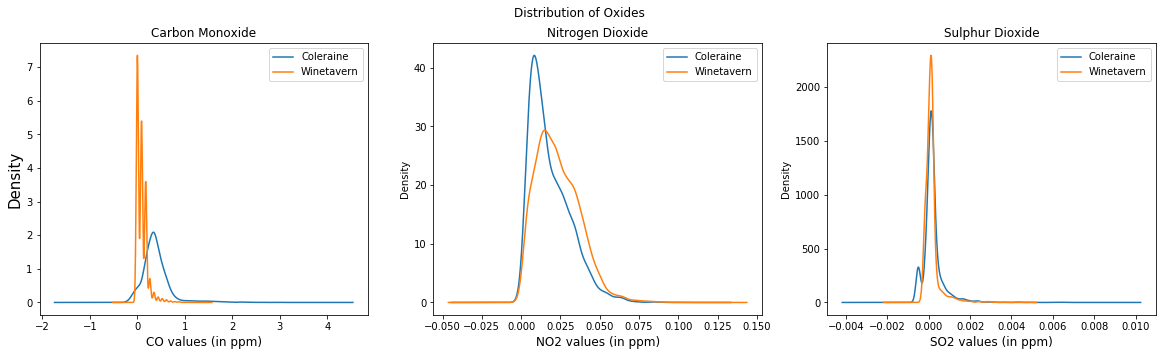

In [119]:
# We want to identify where the oxides values are concentrated and what is their distribution by using density plots.
fig, axes = plt.subplots(ncols=3,figsize=(20,5))
fig.suptitle('Distribution of Oxides')
for label,df in df_airpollhour.groupby(['street']):
    ax1 = df.plot(x='date',y='carbonmonoxide',kind='kde',ax= axes[0],label=label,title='Carbon Monoxide');
    ax1.set_ylabel('Density',fontsize=15)
    ax1.set_xlabel('CO values (in ppm)',fontsize=12)
    ax2 = df.plot(x='date',y='nitrogendioxide',kind='kde',ax= axes[1],label=label,title='Nitrogen Dioxide');
    ax2.set_xlabel('NO2 values (in ppm)',fontsize=12)
    ax3 = df.plot(x='date',y='sulphurdioxide',kind='kde',ax= axes[2],label=label,title='Sulphur Dioxide');
    ax3.set_xlabel('SO2 values (in ppm)',fontsize=12)
# Attention need to be paid for the small percentage of negative values in Carbon Monoxide and Sulphur Dioxide.

In [22]:
# update the airpollhour table with our change
updateCO = """
    UPDATE airpollhour
    SET Carbonmonoxide=0
    WHERE
        Carbonmonoxide <0
;
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(updateCO)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()
        
updateSO2 = """
    UPDATE airpollhour
    SET Sulphurdioxide=0
    WHERE
        Sulphurdioxide <0
;
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(updateSO2)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [23]:
# query the UPDATED airpollhour table as a dataframe for analyzing the results
sqlupdated= "SELECT * FROM airpollhour"

try:
    dbConnection = get_DBConnection()
    df_airpoll_noneg = sqlio.read_sql_query(sqlupdated, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [120]:
df_airpoll_noneg.groupby(['street']).describe().T.iloc[:24,:]
# Now, the negative values have turned into zero

street                   Coleraine   Winetavern
carbonmonoxide  count  3623.000000  3623.000000
                mean      0.391904     0.092297
                std       0.304045     0.115346
                min       0.000000     0.000000
                25%       0.261870     0.000000
                50%       0.349160     0.087290
                75%       0.523740     0.174580
                max       2.967858     1.047479
sulphurdioxide  count  3623.000000  3623.000000
                mean      0.000255     0.000174
                std       0.000471     0.000331
                min       0.000000     0.000000
                25%       0.000000     0.000000
                50%       0.000114     0.000076
                75%       0.000267     0.000185
                max       0.006641     0.003359
nitrogendioxide count  3623.000000  3623.000000
                mean      0.018398     0.023442
                std       0.012809     0.013748
                min       0.000000     0.001169
                25%       0.008344     0.012914
                50%       0.014934     0.021630
                75%       0.026201     0.032578
                max       0.088807     0.096034

In [24]:
# query the airpollhour table for identifying how the oxides values are distributed across the months
sql = """
select to_char(date, 'month') as month, street,
    carbonmonoxide,
    nitrogendioxide,
    sulphurdioxide
from airpollhour
order by street
;
"""
try:
    dbConnection = get_DBConnection()
    df_month = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

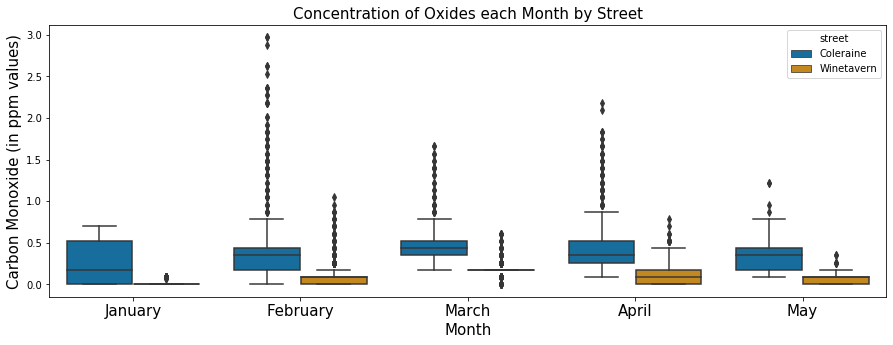

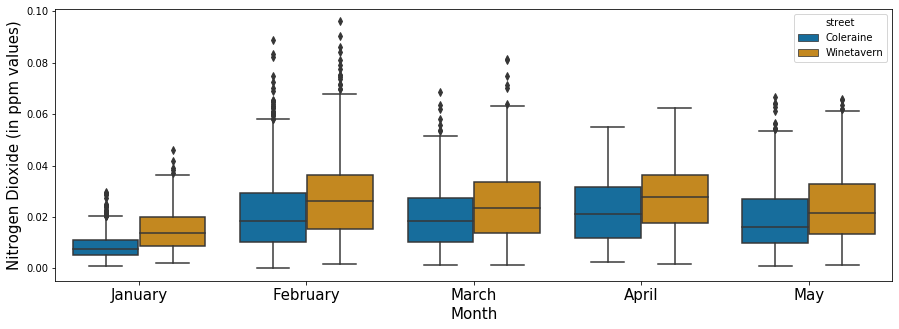

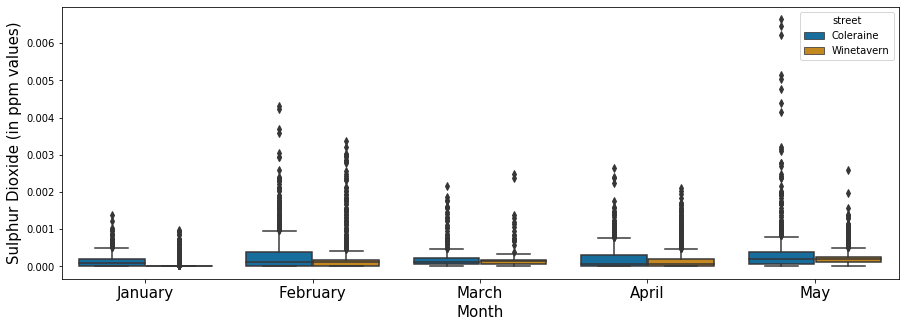

In [124]:
# From the monthly boxplots grouped by Street, it's obvious that there are material differences in the airpollution between the 2 streets
# but there is not a significant relationship between the values across the months.
plt.figure(figsize=(15,5))
fig = sns.boxplot(y='carbonmonoxide', x='month', data=df_month, palette="colorblind",hue='street')
plt.title('Concentration of Oxides each Month by Street', fontsize=15);
plt.xlabel('Month', fontsize=15)
plt.ylabel('Carbon Monoxide (in ppm values)', fontsize=15)
fig.set_xticklabels(['January','February','March','April', 'May'],fontsize=15)
plt.show()
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='nitrogendioxide', x='month', data=df_month, palette="colorblind",hue='street')
plt.xlabel('Month', fontsize=15)
plt.ylabel('Nitrogen Dioxide (in ppm values)', fontsize=15)
fig.set_xticklabels(['January','February','March','April', 'May'],fontsize=15)
plt.show()
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='sulphurdioxide', x='month', data=df_month, palette="colorblind",hue='street')
plt.xlabel('Month', fontsize=15)
plt.ylabel('Sulphur Dioxide (in ppm values)', fontsize=15)
fig.set_xticklabels(['January','February','March','April', 'May'],fontsize=15)
plt.show()
# The behaviour of the oxides doesn't seem very reasonable. It may be probably affected by other factors (eg heating, fossil usage etc)
# or one factor affects the other.

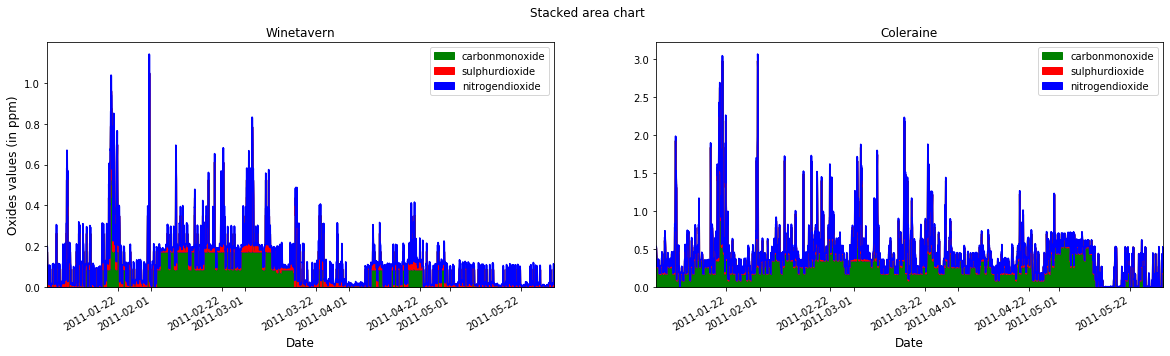

In [102]:
# From the stacked plot area chart and the percentage stacked area chart, it seems that the 2 main concentrated pollutants are
# carbon monoxide and nitrogen dioxide, while sulphur dioxide can be found in too low volumes in both streets. For this reason,
# sulphur dioxide values don't show big difference between the 2 streets across the months.

fig, axes = plt.subplots(ncols=2,figsize=(20,5))
fig.suptitle('Stacked area chart')
ax1 = df_airpoll_noneg.loc[df_airpoll_noneg['street'] == 'Winetavern'].plot.area(x='date',stacked=True,ax= axes[0],title='Winetavern',color='grb');
ax1.set_ylabel('Oxides values (in ppm)',fontsize=12)
ax1.set_xlabel('Date',fontsize=12)
ax1.margins(0, 0) # Set margins to avoid "whitespace"
ax2 = df_airpoll_noneg.loc[df_airpoll_noneg['street'] == 'Coleraine'].plot.area(x='date',stacked=True,ax= axes[1],title='Coleraine',color='grb');
ax2.set_xlabel('Date',fontsize=12)
ax2.margins(0, 0) # Set margins to avoid "whitespace"
plt.show()




,date,street,carbonmonoxide,sulphurdioxide,nitrogendioxide
0,2011-01-01 01:00:00,Winetavern,0.870095,0.00038,0.129524
1,2011-01-01 02:00:00,Winetavern,0.788333,0.00000,0.211667
2,2011-01-01 03:00:00,Winetavern,0.824041,0.00036,0.175599
3,2011-01-01 04:00:00,Winetavern,0.810907,0.00000,0.189093
4,2011-01-01 05:00:00,Winetavern,0.822274,0.00000,0.177726
...,...,...,...,...,...
7241,2011-05-18 19:00:00,Coleraine,0.000000,0.00000,1.000000
7242,2011-05-24 08:00:00,Coleraine,0.000000,0.00000,1.000000
7243,2011-05-24 11:00:00,Coleraine,0.000000,0.00000,1.000000
7244,2011-05-27 08:00:00,Coleraine,0.000000,0.00000,1.000000


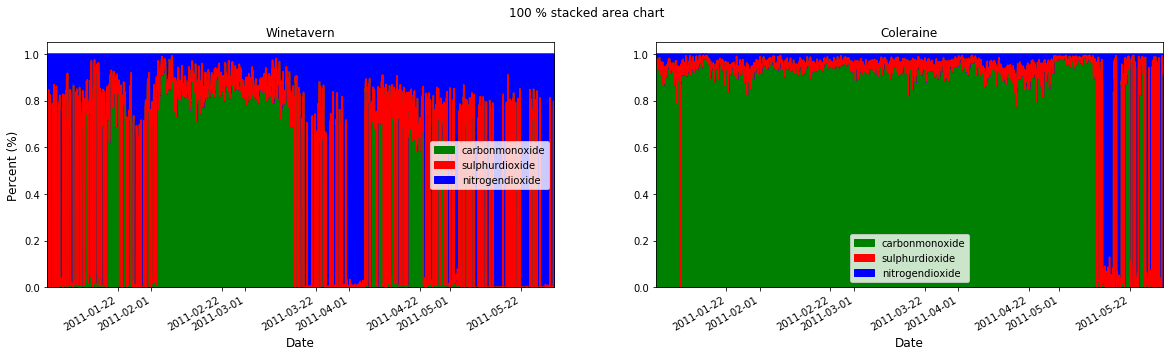

In [101]:
# In order to assess how much each oxide offer (as %), we need to transform the data from raw data to percentage (fraction).
df_perc1 = df_airpoll_noneg.iloc[:,0:]
df_perc1.iloc[:,2:] = df_perc1.iloc[:,2:].divide(df_perc1.iloc[:,2:].sum(axis=1), axis=0)
display_n(df_perc1,10) 

fig, axes = plt.subplots(ncols=2,figsize=(20,5))
fig.suptitle('100 % stacked area chart')
ax1 = df_perc1.loc[df_perc1['street'] == 'Winetavern'].plot.area(x='date',stacked=True,ax= axes[0],title='Winetavern',color='grb');
ax1.set_ylabel('Percent (%)',fontsize=12)
ax1.set_xlabel('Date',fontsize=12)
ax1.margins(0, 0) # Set margins to avoid "whitespace"
ax2 = df_perc1.loc[df_perc1['street'] == 'Coleraine'].plot.area(x='date',stacked=True,ax= axes[1],title='Coleraine',color='grb');
ax2.set_xlabel('Date',fontsize=12)
ax2.margins(0, 0) # Set margins to avoid "whitespace"
plt.show()


In [32]:
# The next 3 steps will be to find out how the oxides values are distributed across the days of the month, across the days
# of the week and across the hours of the day. Are there any significant patterns ?
sqlday = """
SELECT EXTRACT(DAY FROM date) as dayofmonth, 
    street,
    carbonmonoxide,
    nitrogendioxide,
    sulphurdioxide
FROM airpollhour
order by street, dayofmonth
;
"""
sqldow = """
SELECT to_char(date, 'day') as dayofweek, 
    street,
    carbonmonoxide,
    nitrogendioxide,
    sulphurdioxide
FROM airpollhour
order by street, dayofweek
;
"""

sqlhour = """
SELECT  EXTRACT(HOUR FROM date) as hour,
        street,
        carbonmonoxide,
        nitrogendioxide,
        sulphurdioxide
FROM airpollhour
order by street, hour
;
"""
try:
    dbConnection = get_DBConnection()
    df_dayofmonth = sqlio.read_sql_query(sqlday, dbConnection)
    df_dayofweek = sqlio.read_sql_query(sqldow, dbConnection)
    df_hourofday = sqlio.read_sql_query(sqlhour, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

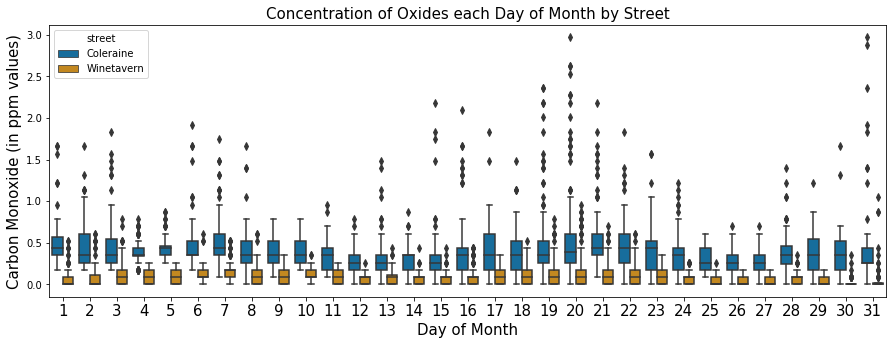

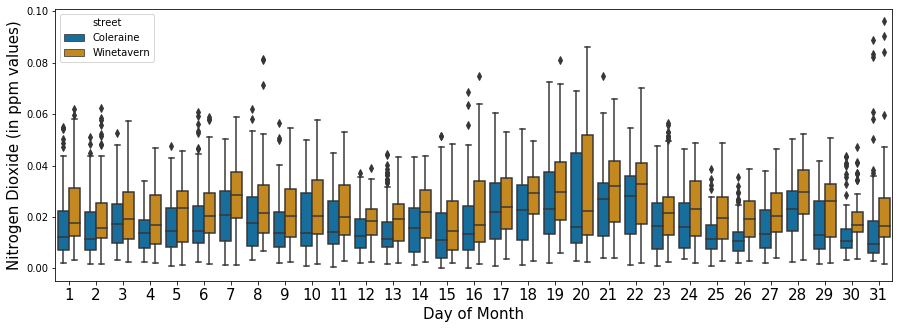

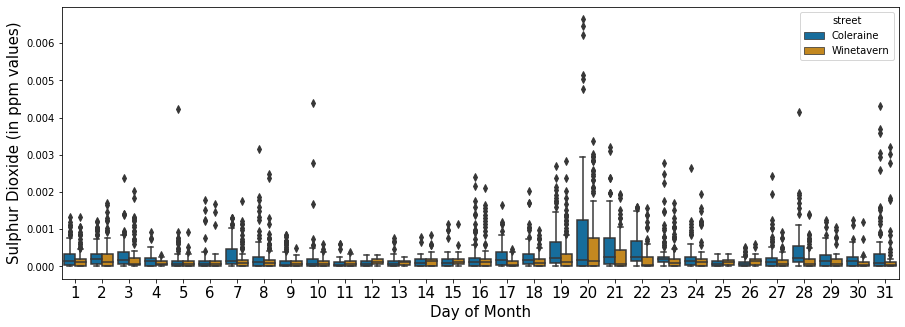

In [125]:
# From the daily boxplots grouped by Street, it's obvious that the differences are more material across the days of months
# between the 2 streets and there is an increase around the 20th day of each month.
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='carbonmonoxide', x='dayofmonth', data=df_dayofmonth, palette="colorblind",hue='street')
plt.title('Concentration of Oxides each Day of Month by Street', fontsize=15);
plt.xlabel('Day of Month', fontsize=15)
plt.ylabel('Carbon Monoxide (in ppm values)', fontsize=15)
fig.set_xticklabels([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],fontsize=15)
plt.show()
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='nitrogendioxide', x='dayofmonth', data=df_dayofmonth, palette="colorblind",hue='street')
plt.xlabel('Day of Month', fontsize=15)
plt.ylabel('Nitrogen Dioxide (in ppm values)', fontsize=15)
fig.set_xticklabels([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],fontsize=15)
plt.show()
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='sulphurdioxide', x='dayofmonth', data=df_dayofmonth, palette="colorblind",hue='street')
plt.xlabel('Day of Month', fontsize=15)
plt.ylabel('Sulphur Dioxide (in ppm values)', fontsize=15)
fig.set_xticklabels([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],fontsize=15)
plt.show()
# The behaviour between the oxides doesn't seem very reasonable. It may be probably affected by other factors (eg heating, fossil usage etc)
# or one factor affects the other.

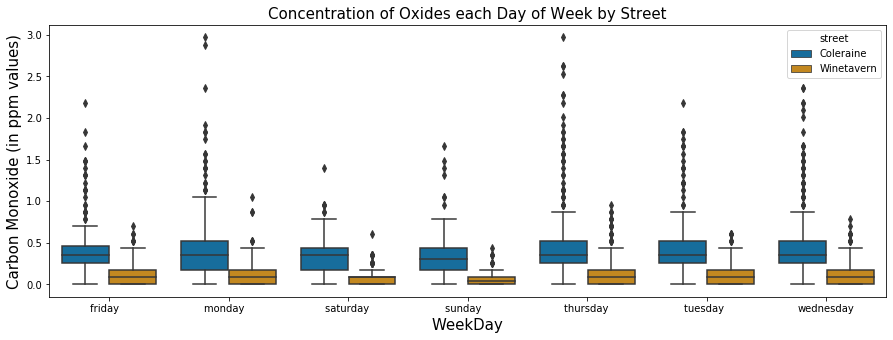

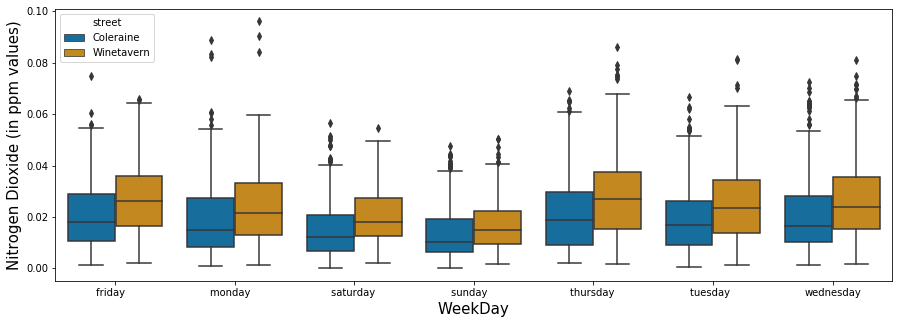

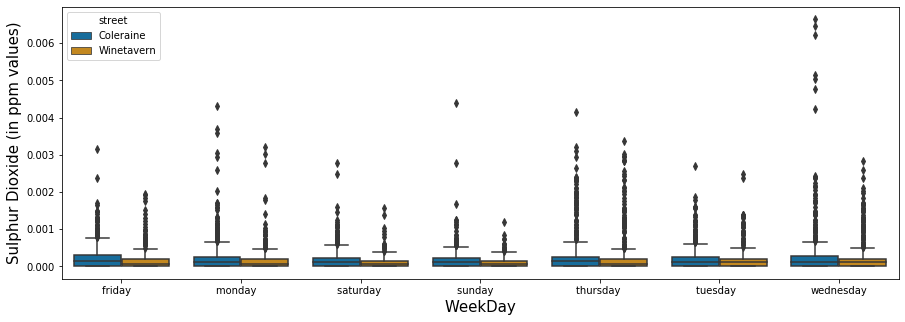

In [126]:
# From the last boxplots for assessing the differences among the weekdays grouped by Street,
# it's obvious that the oxides behaviour is very similar across the weekdays but not between the 2 streets.
# There is a small decrease during the weekend which can be justified by the fact that they are not working days.
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='carbonmonoxide', x='dayofweek', data=df_dayofweek, palette="colorblind",hue='street')
plt.title('Concentration of Oxides each Day of Week by Street', fontsize=15);
plt.xlabel('WeekDay', fontsize=15)
plt.ylabel('Carbon Monoxide (in ppm values)', fontsize=15)
plt.show()
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='nitrogendioxide', x='dayofweek', data=df_dayofweek, palette="colorblind",hue='street')
plt.xlabel('WeekDay', fontsize=15)
plt.ylabel('Nitrogen Dioxide (in ppm values)', fontsize=15)
plt.show()
plt.figure(figsize=(15, 5))
fig = sns.boxplot(y='sulphurdioxide', x='dayofweek', data=df_dayofweek, palette="colorblind",hue='street')
plt.xlabel('WeekDay', fontsize=15)
plt.ylabel('Sulphur Dioxide (in ppm values)', fontsize=15)
plt.show()

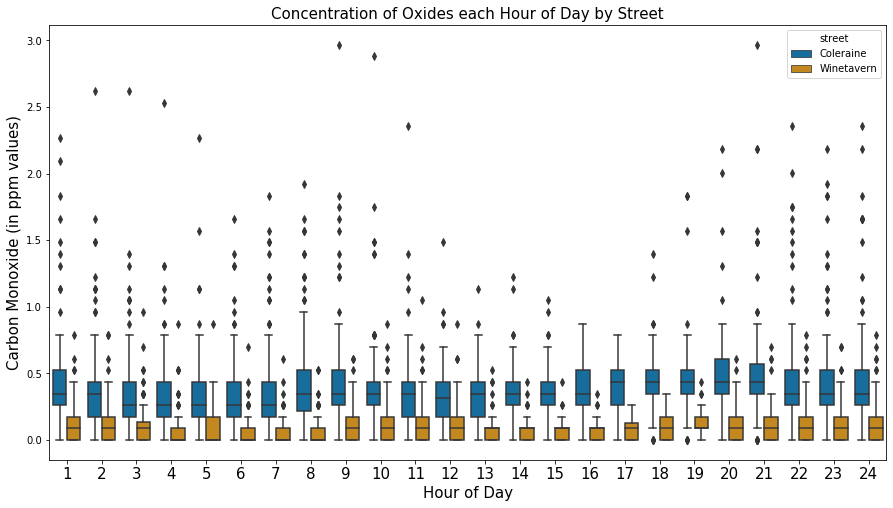

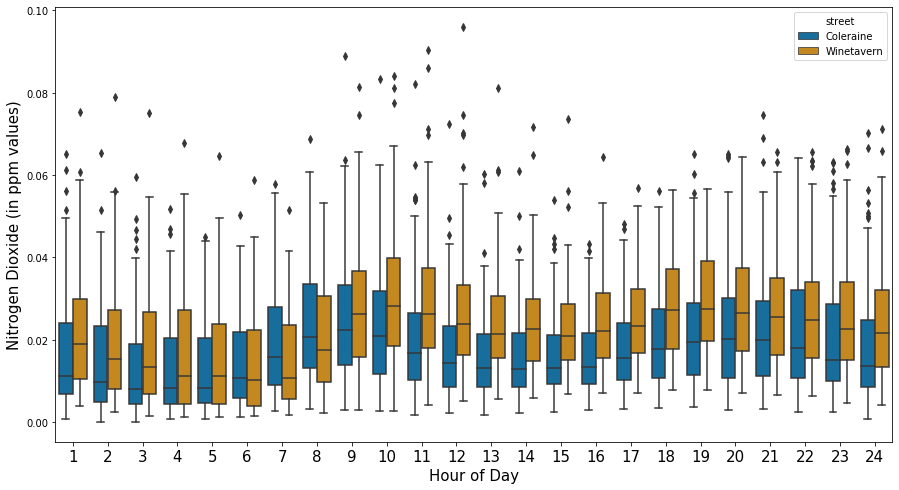

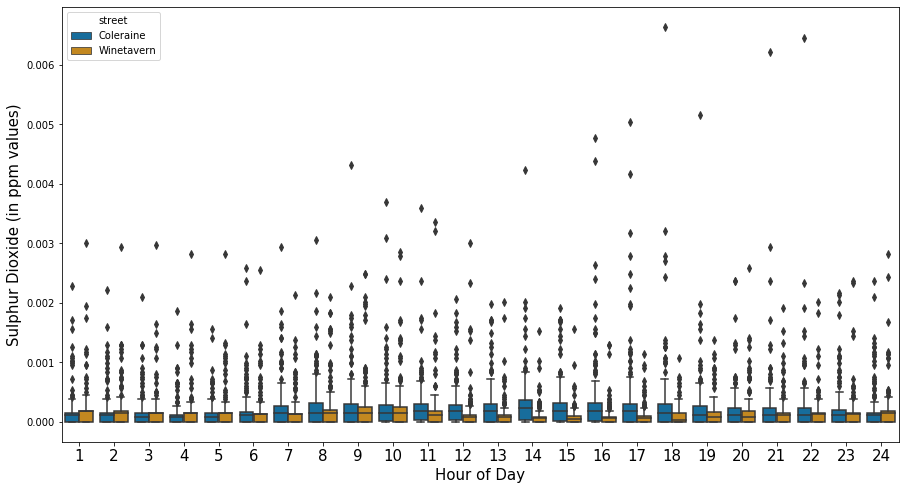

In [55]:
# From the hourly boxplots grouped by Street, it's obvious that the differences are material between the 2 streets 
# and there is an increase in airpollution during the morning rush hours and hours after work from 6 to 8 o'clock.
plt.figure(figsize=(15, 8))
fig = sns.boxplot(y='carbonmonoxide', x='hour', data=df_hourofday, palette="colorblind",hue='street')
plt.title('Concentration of Oxides each Hour of Day by Street', fontsize=15);
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Carbon Monoxide (in ppm values)', fontsize=15)
fig.set_xticklabels([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24],fontsize=15)
plt.show()
plt.figure(figsize=(15, 8))
fig = sns.boxplot(y='nitrogendioxide', x='hour', data=df_hourofday, palette="colorblind",hue='street')
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Nitrogen Dioxide (in ppm values)', fontsize=15)
fig.set_xticklabels([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24],fontsize=15)
plt.show()
plt.figure(figsize=(15, 8))
fig = sns.boxplot(y='sulphurdioxide', x='hour', data=df_hourofday, palette="colorblind",hue='street')
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Sulphur Dioxide (in ppm values)', fontsize=15)
fig.set_xticklabels([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24],fontsize=15)
plt.show()
# However, sulphur dioxide doesn't provide significant information whereas carbon monoxide values shows a clear difference 
# between the values of the 2 streets

#### Creation of the analysis AIRPOLLDAILY dataset and loading it into postgreSQL

In [34]:
createString="""
Create table airpolldaily as
    SELECT DATE(C.DATE) as date,
            C.hour,
            C.street,
            C.avgcarbon as carbonmonoxide,
            C.avgnitrogen as nitrogendioxide,
            C.avgsulphur as sulphurdioxide
    FROM(
        SELECT A.date, A.street, A.hour, 
                round(avg(A.carbonmonoxide),4) as avgcarbon,
                round(avg(A.nitrogendioxide),4) as avgnitrogen,
                round(avg(A.sulphurdioxide),4) as avgsulphur
        FROM
            (SELECT *, 
                EXTRACT(HOUR FROM date) as hour
            FROM airpollhour) as A
        INNER JOIN  
            (SELECT *, 
                EXTRACT(HOUR FROM date) as hour
            FROM airpollhour) as B
        on A.date=B.date and A.street=B.street
        WHERE  B.hour >= A.hour
        AND    B.hour <  A.hour + 24  
        GROUP  BY A.street, A.date, A.hour
        ORDER  BY A.street, A.date, A.hour
        ) as C
    where C.hour = 0
    order by C.street, C.date
;

ALTER TABLE airpolldaily 
DROP COLUMN hour;
"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [53]:
# Query the airpolldaily table as a dataframe for analysis purposes
sql = 'SELECT  * FROM airpolldaily';

try:
    dbConnection = get_DBConnection()
    df_airpolldaily = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [90]:
# Get the Daily Descriptive Stats of the 3 Oxides grouped by Street
df_airpolldaily.groupby(['street']).describe().T.iloc[:24,:]
# Material difference is observed between the 2 streets
# Negative minimum values in carbon monoxide and sulphur dioxide indicate that 

street                  Coleraine  Winetavern
carbonmonoxide  count  150.000000  150.000000
                mean     0.412769    0.104755
                std      0.362433    0.134925
                min      0.000000    0.000000
                25%      0.261900    0.000000
                50%      0.349200    0.087300
                75%      0.523700    0.174600
                max      2.269500    0.785600
nitrogendioxide count  150.000000  150.000000
                mean     0.016843    0.021996
                std      0.014029    0.014036
                min      0.000700    0.004000
                25%      0.006750    0.010525
                50%      0.011150    0.019000
                75%      0.024000    0.029900
                max      0.065200    0.075300
sulphurdioxide  count  150.000000  150.000000
                mean     0.000187    0.000220
                std      0.000342    0.000374
                min      0.000000    0.000000
                25%      0.000000    0.000000
                50%      0.000100    0.000200
                75%      0.000200    0.000200
                max      0.002300    0.003000

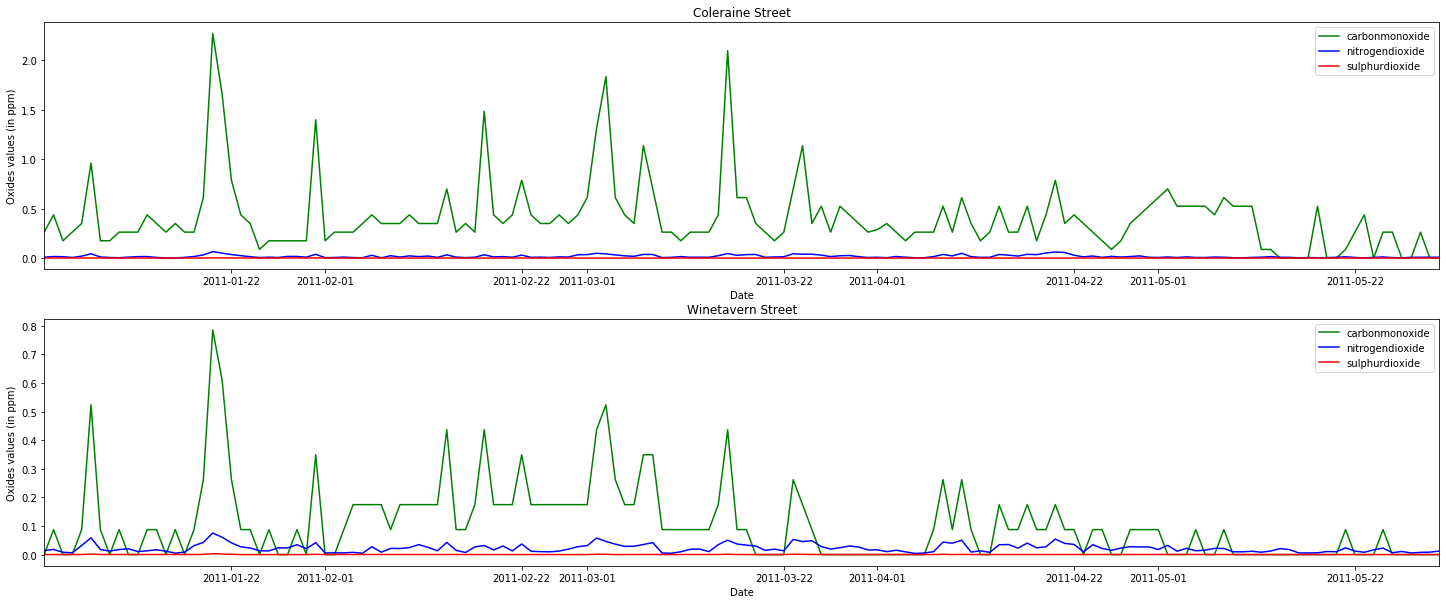

In [108]:
# Line plot 
# daily carbon monoxide values exhibit seasonality with peaks around 22nd and 1st of each month. Its level differs significantly
# between the 2 streets.
# The levels of dioxides are lower and similar in both streets as observed from the descriptive stats above.
fig, axes = plt.subplots(nrows=2);
df_airpolldaily.loc[df_airpolldaily['street'] == 'Coleraine'].plot(x='date',ax=axes[0],figsize=(25,10), title='Coleraine Street',color='gbr')
df_airpolldaily.loc[df_airpolldaily['street'] == 'Winetavern'].plot(x='date',ax=axes[1],figsize=(25,10), title='Winetavern Street',color='gbr')
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Oxides values (in ppm)')
#plt.xticks(df_airpolldaily['date'],rotation=90);

#### INTERACTION BETWEEN THE VARIABLES

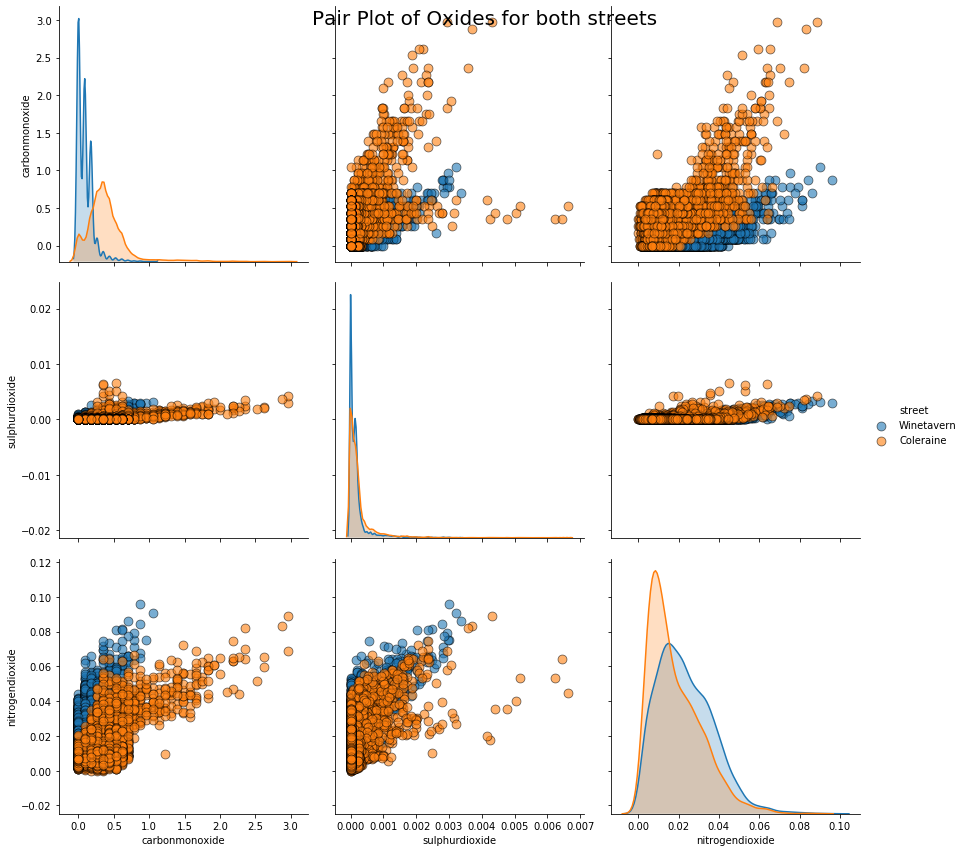

In [271]:
# Pairplots only for numeric variables
# Graphs along the left diagonal represent the distribution of each feature (density plots), whilst graphs on off diagonals 
# show the relationship between variables (INTERACTIONS BETWEEN THE OXIDES).
sns.pairplot(df_airpoll_noneg.iloc[:,1:], hue = 'street',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},height = 4)
# Title 
plt.suptitle('Pair Plot of Oxides for both streets', size = 20);
plt.show()
# There is probably a relationship that we need to uncover.

### Explanatory Analysis

##### GOAL: How much the heating usage affects the two streets' carbon monoxide values?

In [133]:
# Create a dataset which combine Carbon monoxide values and Heating Usage for the period 02-01-2011 to 31-05-2011
# for both streets. Include dummy variable for the street column. This will be our analysis dataset for the our 
# explanatory analysis. 

createString="""
CREATE TABLE CO_HDD_DAILY AS
(
    SELECT  A.DATE,
        CASE 
            WHEN A.STREET = 'Coleraine' THEN 1
            WHEN A.STREET = 'Winetavern' THEN 2
        END AS STREET_IDX,
        A.STREET, A.CARBONMONOXIDE AS CARBON_MONOXIDE, B.HDD AS HEATING_USAGE
    FROM    (
        SELECT  DATE(date) AS date,
                street,
                carbonmonoxide
        FROM    airpolldaily) AS A 
    INNER JOIN  (
        SELECT * FROM dailyhdd
        WHERE DATE >= '2010-01-02' AND DATE <='2011-05-31'
                ) AS B
    ON  A.DATE=B.DATE
    ORDER BY STREET, DATE
)
;

"""
try:
    dbConnection = get_DBConnection()
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [279]:
# Query the CO_HDD_DAILY dataset as a dataframe for helping us in our analysis
sql = "SELECT * FROM CO_HDD_DAILY"

try:
    dbConnection = get_DBConnection()
    df_COHDDDAILY = sqlio.read_sql_query(sql, dbConnection)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

        
# Insert 150 TIME POINTS values for each street from intermediate dataframe into database table
DF_INT = pd.DataFrame(np.append(np.arange(1, 151, 1),np.arange(1, 151, 1)),columns=['Time'])
df_COHDDDAILY.loc[:,'time'] = DF_INT['Time']

In [18]:
# Let's take a look of the relevant part of the data that we will model.
# We have 150 sequential daily measurements of Carbon Monoxide for each street and 150 daily measurements of heating usage
# which are the same for each street. 
# We are interested in how the heating usage affects carbon monoxide measured in each street.
display_n(df_COHDDDAILY[['date','time','street_idx','street', 'carbon_monoxide', 'heating_usage']],5)

,date,time,street_idx,street,carbon_monoxide,heating_usage
0,2011-01-02,1,1,Coleraine,0.2619,12.059479
1,2011-01-03,2,1,Coleraine,0.4364,13.378052
2,2011-01-04,3,1,Coleraine,0.1746,10.641566
3,2011-01-05,4,1,Coleraine,0.2619,10.815097
4,2011-01-06,5,1,Coleraine,0.3492,13.105025
...,...,...,...,...,...,...
295,2011-05-27,146,2,Winetavern,0.0000,4.218295
296,2011-05-28,147,2,Winetavern,0.0000,2.539891
297,2011-05-29,148,2,Winetavern,0.0000,1.732476
298,2011-05-30,149,2,Winetavern,0.0000,3.736493


In [19]:
df_COHDDDAILY['carbon_monoxide'].mean() # 0.2587619999999994 overall mean
df_COHDDDAILY.groupby(['street']).mean().T

street,Coleraine,Winetavern
street_idx,1.000000,2.000000
carbon_monoxide,0.412769,0.104755
heating_usage,6.229494,6.229494
time,75.500000,75.500000


##### STEP 1: Understand the relationship of the observations and which model to apply for answering our question/goal ?

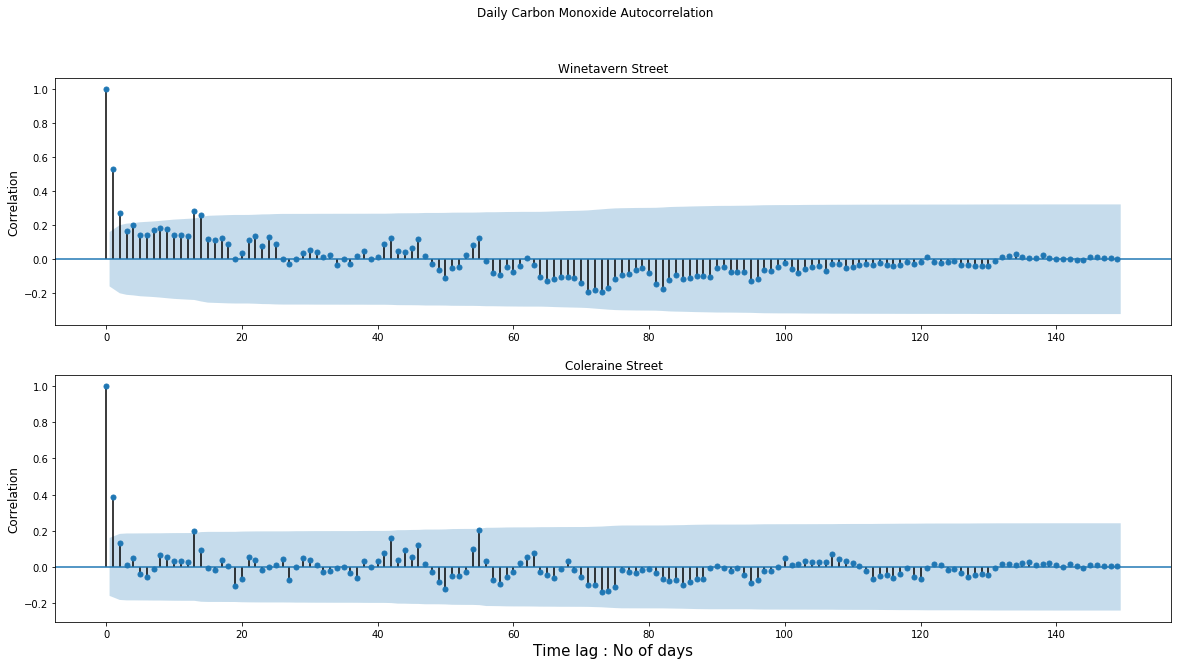

C:\Users\Vdiam\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


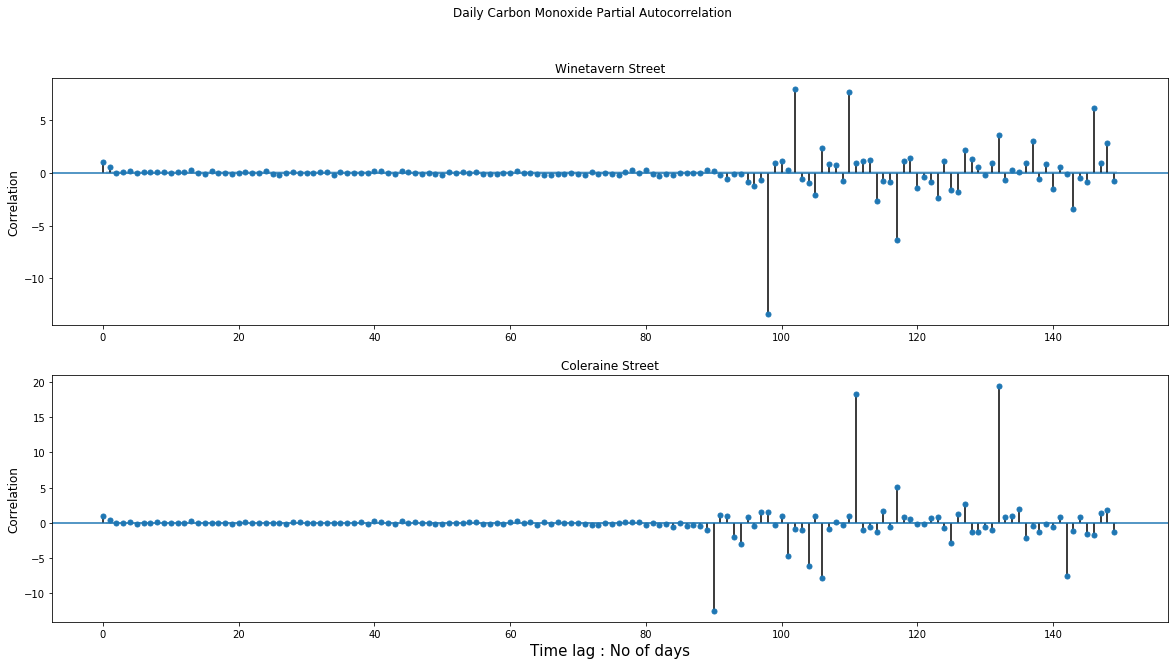

In [20]:
# ACF describes the correlation for CO observations with observations with previous time steps, called lags.
# The shaded region, drawn as a cone, shows the 95% confidence interval.
# Correlation values outside of this cone indicate autocorrelation.
# The PACF plot is an extension of autocorrelation where we have removed the dependence on the intermediate elements within
# the specific lag.

# plt.rcdefaults() # reset style sheet
# plt.style.use('ggplot') # R style ggplots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_COHDDDAILY.loc[df_COHDDDAILY['street']=='Winetavern'][['carbon_monoxide']], lags=149, ax=ax1,title = 'Winetavern Street')
plt.suptitle('Daily Carbon Monoxide Autocorrelation')
plt.ylabel('Correlation',fontsize=12)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(df_COHDDDAILY.loc[df_COHDDDAILY['street']=='Coleraine'][['carbon_monoxide']], lags=149, ax=ax2,title = 'Coleraine Street')
plt.xlabel('Time lag : No of days',fontsize=15)
plt.ylabel('Correlation',fontsize=12)
plt.show()

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(df_COHDDDAILY.loc[df_COHDDDAILY['street']=='Winetavern'][['carbon_monoxide']], lags=149, ax=ax1,title = 'Winetavern Street')
plt.suptitle('Daily Carbon Monoxide Partial Autocorrelation')
plt.ylabel('Correlation',fontsize=12)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_COHDDDAILY.loc[df_COHDDDAILY['street']=='Coleraine'][['carbon_monoxide']], lags=149, ax=ax2,title = 'Coleraine Street')
plt.xlabel('Time lag : No of days',fontsize=15)
plt.ylabel('Correlation',fontsize=12)
plt.show()

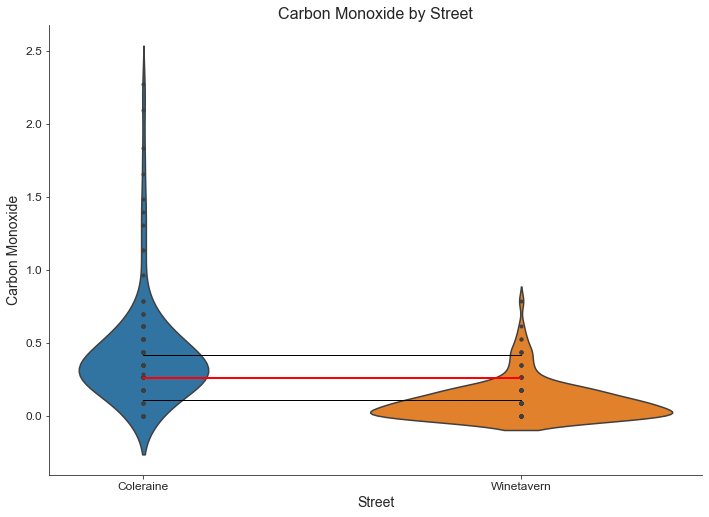

In [68]:
# The difference of carbon monoxide values between the streets is material. Coleraine values are almost double to Winetavern ones.
# As observed, the mean value changes with location and heteroscedasticity (non-constant variance) is present over a street.
# In this way, we can see what proportion of the variance is due to street variability and what proportion is due to 
# individual variability.

#df_COHDDDAILY.boxplot(column=['carbon_monoxide'],by='street',return_type='axes', figsize=(12,5))

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
bplot = sns.violinplot(y='carbon_monoxide', x='street',data=df_COHDDDAILY, inner="points")    
sns.despine()
plt.plot([0, 1], [0.259, 0.259], linewidth=2,c='red')
plt.plot([0, 1], [0.413, 0.413], linewidth=1,c='black')
plt.plot([0, 1], [0.105, 0.105], linewidth=1,c='black')
bplot.axes.set_title("Carbon Monoxide by Street",fontsize=16)
bplot.set_xlabel("Street", fontsize=14)
bplot.set_ylabel("Carbon Monoxide (ppm)",fontsize=14)
bplot.tick_params(labelsize=12)
plt.show()

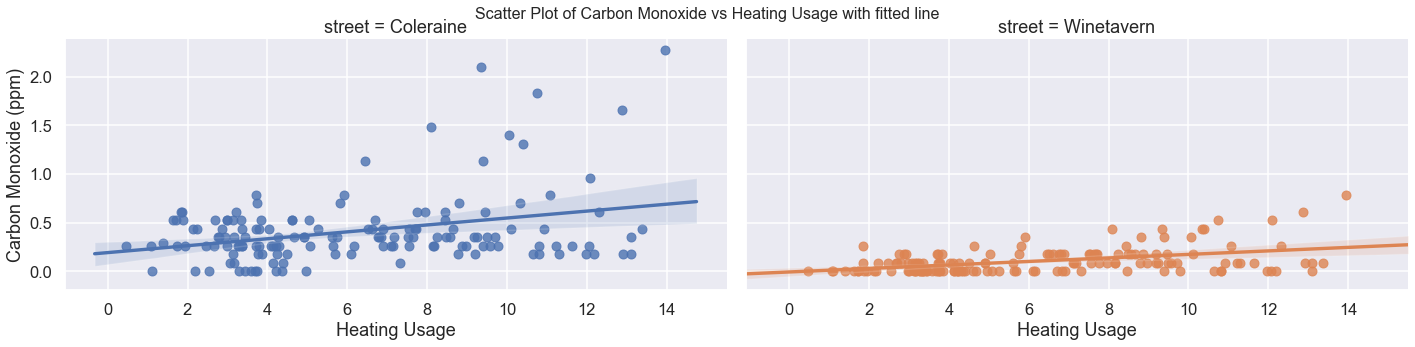

In [104]:
# In this lm plot, it is obvious that the doubled relationship between the two streets holds across the different levels 
# of heating usage but the slope is similar.

# Create lmplot
sns.set(color_codes=True)
sns.set_context("talk")
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2.5})
# sns.set_style("whitegrid")
g = sns.lmplot(x="heating_usage", y="carbon_monoxide", col="street", hue="street",data=df_COHDDDAILY,aspect=2)
g = (g.set_axis_labels("Heating Usage","Carbon Monoxide (ppm)"))
plt.suptitle("Scatter Plot of Carbon Monoxide vs Heating Usage with fitted line", fontsize=16)
plt.show(g)

##### STEP 2: From step 1, it would be wrong to treat measurements within streets as independent datapoints and apply a simple linear model, but a Linear Mixed Model will be the best candidate in order to fit the CO-Heating usage relationship for each street and answer the question:
##### "To What Degree does Carbon Monoxide increase with the Heating Usage for each Street?"

##### In this project, we will use R within Python in order to fit our models and Python in order to visualize and compare our results

In [201]:
# To specify the float vectors that can interface with Python packages, we use the robjects.FloatVector and robjects.StrVector functions.
# Convert carbon monoxide, street and heating usage variables to R objects
r_street = robjects.StrVector(df_COHDDDAILY['street'])
r_street_idx = robjects.FactorVector(df_COHDDDAILY['street_idx']) # 1: Coleraine, 2: Winetavern
r_time_point = robjects.FloatVector(df_COHDDDAILY['time'])
r_co = robjects.FloatVector(df_COHDDDAILY['carbon_monoxide']) 
r_heat = robjects.FloatVector(df_COHDDDAILY['heating_usage'])
# Now, we will specify our R dataframe by using the robjects.DataFrame function. 
coheat_r = robjects.DataFrame({"time_point":r_time_point,"street_idx":r_street_idx, "street":r_street,"co":r_co, "heat_usage":r_heat})

In [183]:
# RANDOM EFFECTS ANOVA
# Without any predictors, only random effect of street
rand_effects_anova_formula = robjects.Formula("co ~ 1 + (1|street_idx) ") 
rand_effects_anova = r_lmm(formula=rand_effects_anova_formula, data=coheat_r) 
print(r_summary(rand_effects_anova))

Linear mixed model fit by REML ['lmerMod']

Formula: co ~ 1 + (1 | street_idx)

   Data: structure(list(time_point = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  

11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  

27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,  

43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,  

59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,  

75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,  

91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104,  

105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,  

118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,  

131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,  

144, 145, 146, 147, 148, 149, 150, 1, 2, 3, 4, 5, 6, 7, 8, 9,  

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  

26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,  

42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5

In [184]:
# INTRA-CLASS CORRELATION
# Around 39% of the variability is attributed to the street.
icc_res = r_icc.ICCbare("street_idx", "co", data=coheat_r)
icc_val = icc_res[0] # icc_val now holds the icc value
icc_val

0.38562475804782925

In [127]:
# RANDOM INTERCEPTS MODEL
# With a predictor in the model: Heating Usage
# We allow the intercepts to vary between streets (groups), BUT we don’t allow the slopes to vary
# The intercept is different for each level of street.
rand_intercept_formula = robjects.Formula("co ~ 1 + heat_usage + (1|street_idx) ")
rand_intercept = r_lmm(formula=rand_intercept_formula, data=coheat_r) 
print(r_summary(rand_intercept))

Linear mixed model fit by REML ['lmerMod']

Formula: co ~ 1 + heat_usage + (1 | street_idx)

   Data: structure(list(time_point = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  

11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  

27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,  

43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,  

59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,  

75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,  

91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104,  

105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,  

118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,  

131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,  

144, 145, 146, 147, 148, 149, 150, 1, 2, 3, 4, 5, 6, 7, 8, 9,  

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  

26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,  

42, 43, 44, 45, 46, 47, 48, 49, 

In [138]:
# RANDOM SLOPES MODEL
# This model allows the slopes to vary, but fixes the intercepts to the same value
rand_slope_formula = robjects.Formula("co ~ 1 + heat_usage + (-1 + heat_usage |street_idx) ")
rand_slope = r_lmm(formula=rand_slope_formula, data=coheat_r) 
print(r_summary(rand_slope))

Linear mixed model fit by REML ['lmerMod']

Formula: co ~ 1 + heat_usage + (-1 + heat_usage | street_idx)

   Data: structure(list(time_point = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  

11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  

27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,  

43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,  

59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,  

75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,  

91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104,  

105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,  

118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,  

131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,  

144, 145, 146, 147, 148, 149, 150, 1, 2, 3, 4, 5, 6, 7, 8, 9,  

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  

26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,  

42, 43, 44, 45, 46

In [234]:
# RANDOM INTERCEPTS AND SLOPES
rand_slope_int_formula = robjects.Formula("co ~ 1 + heat_usage + (heat_usage |street_idx)")
rand_slope_int = r_lmm(formula=rand_slope_int_formula, data=coheat_r) 
print(r_summary(rand_slope_int))

Linear mixed model fit by REML ['lmerMod']

Formula: co ~ 1 + heat_usage + (heat_usage | street_idx)

   Data: structure(list(time_point = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  

11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  

27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,  

43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,  

59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,  

75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,  

91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104,  

105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,  

118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,  

131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,  

144, 145, 146, 147, 148, 149, 150, 1, 2, 3, 4, 5, 6, 7, 8, 9,  

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  

26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,  

42, 43, 44, 45, 46, 47,

In [265]:
print(r_coef(rand_slope_int)) # coefficients for the 2 streets. Both in intercepts and slopes differ for each street.

$street_idx

   (Intercept) heat_usage

1  0.190482238 0.03546065

2 -0.006785709 0.01812756



attr(,"class")

[1] "coef.mer"



##### STEP 3: MODEL DIAGNOSTICS --> COMPARISON --> RESULTS

In [258]:
# LINEAR MIXED MODELS

# Within the build of the three models, street is considered as a group!!!

# RANDOM EFFECTS MODEL
# without any predictors
rand_eff = smf.mixedlm("carbon_monoxide ~ 1", df_COHDDDAILY, groups=df_COHDDDAILY["street_idx"])
rand_eff_fit = rand_eff.fit()

# RANDOM INTERCEPTS MODEL
# We will investigate how the carbon monoxide relates to the heating usage, while controlling for the impact of streets 
# by allowing for a random intercept for each streets
rand_inter = smf.mixedlm("carbon_monoxide ~ heating_usage", df_COHDDDAILY, groups=df_COHDDDAILY["street_idx"])
rand_int_fit = rand_inter.fit()

# RANDOM SLOPES AND INTERCEPTS MODEL
# construct our model, but this time we will have a random intercept AND a random slope with respect to street
rand_slope_inter = smf.mixedlm("carbon_monoxide ~ heating_usage", df_COHDDDAILY, groups=df_COHDDDAILY["street_idx"],
                               re_formula="~heating_usage")
rand_slope_int_fit = rand_slope_inter.fit()


print(rand_eff_fit.summary())
print(rand_int_fit.summary())
print(rand_slope_int_fit.summary())

C:\Users\Vdiam\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Vdiam\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\Vdiam\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Vdiam\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\Vdiam\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Vdiam\Anaconda3\lib

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: carbon_monoxide
No. Observations: 300     Method:             REML           
No. Groups:       2       Scale:              0.0748         
Min. group size:  150     Likelihood:         -41.7108       
Max. group size:  150     Converged:          Yes            
Mean group size:  150.0                                      
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
---------------------------------------------------------------
Intercept    0.259      0.154   1.680   0.093   -0.043    0.561
Group Var    0.047      0.246                                  

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: carbon_monoxide
No. Observations: 300     Method:             REML           
No. Groups:       2       Scale:              0.0671         
Min. group size:  150

In [263]:
# COMPARISON of the models based on RMSE !!!

y = df_COHDDDAILY["carbon_monoxide"]

y_predict0 = rand_eff_fit.fittedvalues
RMSE0 = sqrt(((y-y_predict0)**2).values.mean())

y_predict1 = rand_int_fit.fittedvalues
RMSE1 = sqrt(((y-y_predict1)**2).values.mean())

y_predict2 = rand_slope_int_fit.fittedvalues
RMSE2 = sqrt(((y-y_predict2)**2).values.mean())

results = pd.DataFrame()
results["Linear Mixed Model"] = ["Random Effects"]
results["RMSE"] = RMSE0
results.loc[1] = ["Random Intercepts", RMSE1]
results.loc[2] = ["Random Intercepts & Slopes", RMSE2]
results

,Linear Mixed Model,RMSE
0,Random Effects,0.272553
1,Random Intercepts,0.257725
2,Random Intercepts & Slopes,0.256424


###### IMPORTANT RESULT !!! 

###### The RMSEs are very similar but let's take a look at the models' R summary in order to take our best model.
###### Both have the same Fixed Effects and the only difference is in Random effects. Between the 2 residuals, the difference is very small (0.067 vs 0.066) with a slightly better fit for the Random Slopes and Intercepts Model at the individual/measurements level. Although the improvement does not seem material, the correlation between the fixed values in the Random Slopes and Intercepts Model shows us something important for our analysis which replies our QUESTION.

###### The correlation between the slope and the intercept across the measurements is 0.72
###### That means that for those measurements with high intercepts, they tend to have large slopes. The higher the monoxide measurements are (intercept), the more it increases as heating usage increase (slope).

###### From above, we understant that the heating usage is a parameter which affects the  carbon monoxide values and differs the air pollution values for the 2 streets. That' s a reason why air pollution is at higher levels in Coleraine Street. Although these 2 streets are very close, they have taken separate measurements because they are showing a different behaviour.

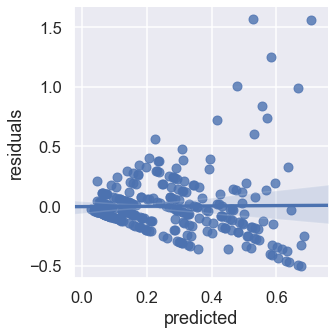

In [273]:
# MODEL DIAGNOSTICS PLOTS OF THE BEST MODEL

# So, let's plot the predictions for the "Random Slopes and Intercepts" model
performance = pd.DataFrame()
performance["residuals"] = rand_slope_int_fit.resid.values
performance["heating_usage"] = df_COHDDDAILY["heating_usage"]
performance["predicted"] = rand_slope_int_fit.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance);

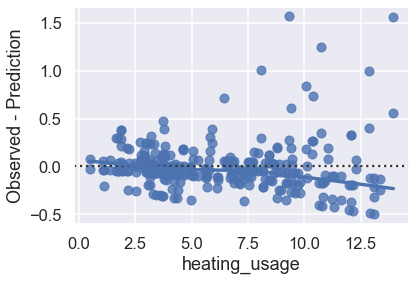

In [274]:
ax = sns.residplot(x = "heating_usage", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show();